# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import time
import lightgbm as lgb
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import (
    GridSearchCV, 
    train_test_split)
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler)
import warnings
warnings.filterwarnings("ignore")
import sklearn
!pip install scikit-learn==1.1.3

In [2]:
IS_LOCAL = True

if IS_LOCAL:
    data = pd.read_csv(r"C:\Users\yana\Desktop\autos.csv")
else:
    data = pd.read_csv("/datasets/autos.csv")

In [3]:
def prepare(df): #фунция предобработки данных
    display(df.head())
    display(df.info())
    display(df.isna().sum())
    display(df.duplicated().sum())

In [4]:
prepare(data)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

4

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
def plot_f(data, column_): #функция для построения графиков размаха для данных
    data.boxplot(column=[column_])
    plt.show()

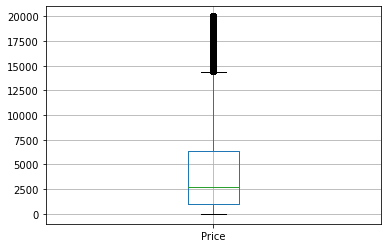

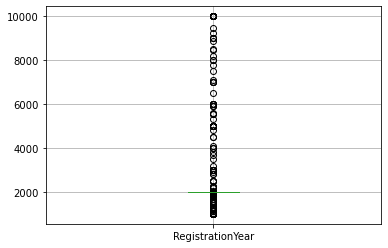

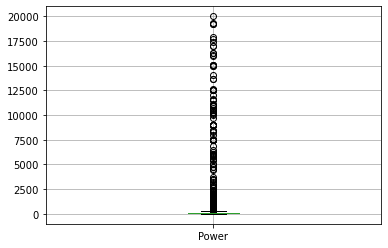

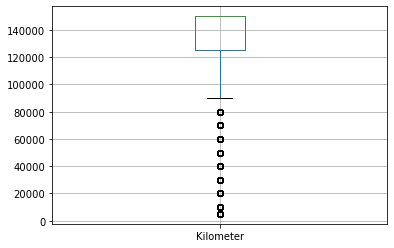

In [7]:
plot_f(data, 'Price')
plot_f(data, 'RegistrationYear')
plot_f(data, 'Power')
plot_f(data, 'Kilometer')

In [8]:
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%dT%H:%M:%S')
data['DateCreated'] = data['DateCreated'].apply(lambda t: t.year)

In [9]:
data = data[(data.RegistrationYear < data.DateCreated)] #убрали анкеты, где год выпуска машины новее даты загрузки анкеты

In [10]:
i = data[data.duplicated()].index
data.loc[i] 

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016,0,36391,2016-03-18 18:46:15


Дубли удалять не будем, тк данные по машинам не уникальные(за уникальность отвечае вин, у нас его нет в данных) и совпадения в одном регионе возможны

In [11]:
data['Repaired'] = data['Repaired'].fillna(value = 'no')

Заполняем пропуски в графе про ремонт, тк те, кто не заполнил данную графу руководствовались скорее всего тем, что машина не ремонтирована, значит заполнять не будем

In [12]:
data['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [13]:
data = data.replace({'FuelType' : { 'gasoline' : 'petrol'}}) #gasolin и petrol одно и то же

In [14]:
data = data[data.Price != 0] #удалим строки с ценой 0

In [15]:
data = data[data['Price'] >= 500] #удалим строки с ценой менее 500 евро

In [16]:
display(len(data[data['Price']>= 15000]))
data = data[data['Price'] <= 15000] #удалим машины с высокой стоимостью

15128

In [17]:
data = data[data['Power'] <= 1000] #уберем выбросы из сверхмашин

In [18]:
data = data[data['Power']>= 25] #выбросов немного больше 10%

In [19]:
data = data.dropna(subset=['Model']) #без конкретной модели удаляем строки

In [20]:
display(data['Gearbox'].unique())
len(data[data['Gearbox']== 'manual']) 
data['Gearbox'] = data['Gearbox'].fillna(value = 'manual') #больший процент за механикой, заполним пропуски этим значением

array(['auto', 'manual', nan], dtype=object)

In [21]:
data = data[data['RegistrationYear'].between(1965, 2016)] #уберем модели из далекого прошлого и будущего

In [22]:
data['VehicleType'].value_counts()
data = data.dropna(subset=['VehicleType']) 
#в типе кузова сложно чем либо заполнить, удалим строки с пропусками

In [23]:
data['FuelType'].value_counts()
data['FuelType'] = data['FuelType'].fillna(value = 'petrol') #здесь можем заполнить пропуски наиболее частым вариантом

In [24]:
data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'PostalCode'], axis=1) 
#удаляем неинформативные для обучения столбцы

In [25]:
data.reset_index(drop= True , inplace= True )

In [26]:
prepare(data)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,9800,suv,2004,auto,163,grand,125000,petrol,jeep,no
1,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
2,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
3,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
4,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248316 entries, 0 to 248315
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             248316 non-null  int64 
 1   VehicleType       248316 non-null  object
 2   RegistrationYear  248316 non-null  int64 
 3   Gearbox           248316 non-null  object
 4   Power             248316 non-null  int64 
 5   Model             248316 non-null  object
 6   Kilometer         248316 non-null  int64 
 7   FuelType          248316 non-null  object
 8   Brand             248316 non-null  object
 9   Repaired          248316 non-null  object
dtypes: int64(4), object(6)
memory usage: 18.9+ MB


None

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

44303

**Предобработка данных** включила в себя заполнения пропусков, исключение выбросов в данных, исключения ненужных для машинного обучения столбцов.

## Обучение моделей

In [28]:
x = data.drop(['Price'], axis=1) #выборки для обучения моделей
y = data['Price']
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.25, random_state=12345) 

In [29]:
#категориальные признаки для OHE 
ohe_features_lin = x_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_lin)

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


In [30]:
#численные признаки
num_features = x_train.select_dtypes(exclude='object').columns.to_list()
num_features

['RegistrationYear', 'Power', 'Kilometer']

In [31]:
models_train = set(x_train['Model'].unique())
models_test = set(x_valid['Model'].unique())
num_models_train = len(models_train)
num_models_test = len(models_test)
print(f'''
Количество уникальных значений признка "model" 
в обеих выборках одинаковое: {num_models_train == num_models_test}
''')
print(f'''
Уникальные значения признка "model" 
в обеих выборках одинаковые: {models_train == models_test}
''')
print(f'''
Только в тренировочной выборке есть значения: {models_train - models_test}
''')
print(f'''
Только в тестовой выборке есть значения: {models_test - models_train}
''')


Количество уникальных значений признка "model" 
в обеих выборках одинаковое: False


Уникальные значения признка "model" 
в обеих выборках одинаковые: False


Только в тренировочной выборке есть значения: {'q3', 'rangerover', 'samara', 'serie_3'}


Только в тестовой выборке есть значения: set()



In [32]:
x_train_lin = x_train.copy()
x_test_lin = x_valid.copy()

In [33]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(x_train_lin[ohe_features_lin])

# добавляем закодированные признаки в X_train_ohe
x_train_lin[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(x_train_lin[ohe_features_lin])

# удаляем незакодированные категориальные признаки (изначальные колонки)
x_train_lin = x_train_lin.drop(ohe_features_lin, axis=1)

# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
x_train_lin[num_features] = scaler.fit_transform(x_train_lin[num_features])

# смотрим на результат
x_train_lin.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
85564,-0.464923,-0.371518,0.579905,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93530,0.578282,-0.352031,-1.701226,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
15360,1.099884,-1.170486,-1.986367,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117016,0.926017,0.310528,-1.986367,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173873,0.404414,0.174119,-0.132949,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую
x_test_lin[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(x_test_lin[ohe_features_lin])

x_test_lin = x_test_lin.drop(ohe_features_lin, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую
x_test_lin[num_features] = scaler.transform(
    x_test_lin[num_features]
)

# смотрим на результат
x_test_lin.head()

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_yes
20022,0.926017,-0.293570,0.579905,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25584,-0.812657,-0.585875,-0.132949,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45986,0.056680,0.583347,0.579905,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
189429,0.404414,2.025387,0.579905,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
60890,1.099884,0.115658,0.579905,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [35]:
# получилось одинаковое количество признаков
x_train_lin.shape, x_test_lin.shape

((186237, 303), (62079, 303))

In [36]:
model_lin = LinearRegression()
param_grid_lin = {'n_jobs' : [1, 10]}
model_lin_g = GridSearchCV(model_lin, param_grid = param_grid_lin, scoring='neg_root_mean_squared_error')
model_lin_fin = model_lin_g.fit(x_train_lin, y_train)

In [37]:
print('Best Score: %s' % model_lin_fin.best_score_)
ress = pd.DataFrame(model_lin_fin.cv_results_)
display(ress)
display(ress[ress['rank_test_score']== 1])
fit_time = ress[ress['rank_test_score']==1]['mean_fit_time'].values[0]
predict_time = ress[ress['rank_test_score'] ==1]['mean_score_time'].values[0]
print(f'Fit time: {fit_time}, predict time: {predict_time}')

Best Score: -2087.291411410351


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_jobs,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.216508,0.360503,0.024548,0.005495,1,{'n_jobs': 1},-2067.350784,-2084.870574,-2071.416254,-2101.814625,-2111.00482,-2087.291411,16.904196,1
1,2.883121,0.189084,0.025204,0.007047,10,{'n_jobs': 10},-2067.350784,-2084.870574,-2071.416254,-2101.814625,-2111.00482,-2087.291411,16.904196,1


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_jobs,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.216508,0.360503,0.024548,0.005495,1,{'n_jobs': 1},-2067.350784,-2084.870574,-2071.416254,-2101.814625,-2111.00482,-2087.291411,16.904196,1
1,2.883121,0.189084,0.025204,0.007047,10,{'n_jobs': 10},-2067.350784,-2084.870574,-2071.416254,-2101.814625,-2111.00482,-2087.291411,16.904196,1


Fit time: 3.216508150100708, predict time: 0.024548053741455078


In [38]:
# catboost
catboost = CatBoostRegressor(loss_function='RMSE', random_state = 12345)
parameters_cat = {'depth':[9,10], 'learning_rate':np.arange(0.1,0.2)}
catboost_g = GridSearchCV(catboost, param_grid=parameters_cat, scoring='neg_root_mean_squared_error')
catboost_fin = catboost_g.fit(x_train, y_train, cat_features=["VehicleType","Gearbox","Model","FuelType","Brand","Repaired"])

0:	learn: 3435.3501427	total: 295ms	remaining: 4m 55s
1:	learn: 3205.7459920	total: 429ms	remaining: 3m 34s
2:	learn: 3006.0096365	total: 558ms	remaining: 3m 5s
3:	learn: 2827.3536205	total: 684ms	remaining: 2m 50s
4:	learn: 2670.3234713	total: 805ms	remaining: 2m 40s
5:	learn: 2531.9210625	total: 927ms	remaining: 2m 33s
6:	learn: 2406.4037589	total: 1.05s	remaining: 2m 28s
7:	learn: 2300.0253564	total: 1.16s	remaining: 2m 23s
8:	learn: 2202.7984097	total: 1.27s	remaining: 2m 19s
9:	learn: 2120.9056903	total: 1.4s	remaining: 2m 18s
10:	learn: 2048.3165157	total: 1.5s	remaining: 2m 15s
11:	learn: 1985.6834378	total: 1.62s	remaining: 2m 13s
12:	learn: 1927.9826094	total: 1.74s	remaining: 2m 11s
13:	learn: 1878.1811772	total: 1.87s	remaining: 2m 11s
14:	learn: 1834.7379853	total: 1.99s	remaining: 2m 10s
15:	learn: 1795.5844210	total: 2.1s	remaining: 2m 8s
16:	learn: 1760.1197381	total: 2.21s	remaining: 2m 8s
17:	learn: 1727.1079648	total: 2.33s	remaining: 2m 6s
18:	learn: 1701.5117165	tot

150:	learn: 1356.1124226	total: 17.7s	remaining: 1m 39s
151:	learn: 1355.6908039	total: 17.8s	remaining: 1m 39s
152:	learn: 1355.1390997	total: 18s	remaining: 1m 39s
153:	learn: 1354.7784600	total: 18.1s	remaining: 1m 39s
154:	learn: 1353.7937398	total: 18.3s	remaining: 1m 39s
155:	learn: 1353.1477247	total: 18.4s	remaining: 1m 39s
156:	learn: 1352.6586410	total: 18.5s	remaining: 1m 39s
157:	learn: 1352.3612714	total: 18.6s	remaining: 1m 39s
158:	learn: 1351.9050848	total: 18.8s	remaining: 1m 39s
159:	learn: 1351.3021541	total: 18.9s	remaining: 1m 39s
160:	learn: 1351.0988737	total: 19s	remaining: 1m 38s
161:	learn: 1350.6216723	total: 19.1s	remaining: 1m 38s
162:	learn: 1349.8382527	total: 19.2s	remaining: 1m 38s
163:	learn: 1348.9879241	total: 19.3s	remaining: 1m 38s
164:	learn: 1348.4945025	total: 19.4s	remaining: 1m 38s
165:	learn: 1348.1006229	total: 19.5s	remaining: 1m 38s
166:	learn: 1347.6712768	total: 19.6s	remaining: 1m 37s
167:	learn: 1347.0711559	total: 19.8s	remaining: 1m 

297:	learn: 1298.4101280	total: 34.5s	remaining: 1m 21s
298:	learn: 1298.0163539	total: 34.6s	remaining: 1m 21s
299:	learn: 1297.8780481	total: 34.7s	remaining: 1m 21s
300:	learn: 1297.5623001	total: 34.8s	remaining: 1m 20s
301:	learn: 1297.3638023	total: 34.9s	remaining: 1m 20s
302:	learn: 1296.8649124	total: 35s	remaining: 1m 20s
303:	learn: 1296.5481757	total: 35.2s	remaining: 1m 20s
304:	learn: 1296.4678518	total: 35.3s	remaining: 1m 20s
305:	learn: 1296.1743997	total: 35.4s	remaining: 1m 20s
306:	learn: 1295.9886235	total: 35.5s	remaining: 1m 20s
307:	learn: 1295.8597035	total: 35.6s	remaining: 1m 20s
308:	learn: 1295.5882273	total: 35.7s	remaining: 1m 19s
309:	learn: 1295.1288606	total: 35.8s	remaining: 1m 19s
310:	learn: 1294.9131459	total: 35.9s	remaining: 1m 19s
311:	learn: 1294.7900316	total: 36.1s	remaining: 1m 19s
312:	learn: 1294.5429596	total: 36.2s	remaining: 1m 19s
313:	learn: 1294.1773853	total: 36.3s	remaining: 1m 19s
314:	learn: 1294.0840089	total: 36.4s	remaining: 1

445:	learn: 1264.9475160	total: 50.6s	remaining: 1m 2s
446:	learn: 1264.6751236	total: 50.7s	remaining: 1m 2s
447:	learn: 1264.5724103	total: 50.8s	remaining: 1m 2s
448:	learn: 1264.4529465	total: 50.9s	remaining: 1m 2s
449:	learn: 1264.1742335	total: 51s	remaining: 1m 2s
450:	learn: 1264.1274182	total: 51.1s	remaining: 1m 2s
451:	learn: 1263.9381650	total: 51.2s	remaining: 1m 2s
452:	learn: 1263.7327724	total: 51.3s	remaining: 1m 1s
453:	learn: 1263.5409550	total: 51.4s	remaining: 1m 1s
454:	learn: 1263.4274937	total: 51.5s	remaining: 1m 1s
455:	learn: 1263.3850295	total: 51.6s	remaining: 1m 1s
456:	learn: 1263.0561665	total: 51.7s	remaining: 1m 1s
457:	learn: 1262.9347744	total: 51.9s	remaining: 1m 1s
458:	learn: 1262.7238463	total: 52s	remaining: 1m 1s
459:	learn: 1262.6083471	total: 52s	remaining: 1m 1s
460:	learn: 1262.2688770	total: 52.2s	remaining: 1m
461:	learn: 1262.1684178	total: 52.3s	remaining: 1m
462:	learn: 1261.9763524	total: 52.4s	remaining: 1m
463:	learn: 1261.7007992	

598:	learn: 1240.7135430	total: 1m 7s	remaining: 45.1s
599:	learn: 1240.3375196	total: 1m 7s	remaining: 45s
600:	learn: 1240.0966249	total: 1m 7s	remaining: 44.9s
601:	learn: 1239.9422403	total: 1m 7s	remaining: 44.7s
602:	learn: 1239.7692547	total: 1m 7s	remaining: 44.6s
603:	learn: 1239.6714966	total: 1m 7s	remaining: 44.5s
604:	learn: 1239.5732405	total: 1m 8s	remaining: 44.4s
605:	learn: 1239.3626119	total: 1m 8s	remaining: 44.3s
606:	learn: 1239.2462293	total: 1m 8s	remaining: 44.2s
607:	learn: 1239.1445040	total: 1m 8s	remaining: 44.1s
608:	learn: 1238.7209252	total: 1m 8s	remaining: 44s
609:	learn: 1238.5819148	total: 1m 8s	remaining: 43.8s
610:	learn: 1238.5073223	total: 1m 8s	remaining: 43.7s
611:	learn: 1238.4117740	total: 1m 8s	remaining: 43.6s
612:	learn: 1238.2755276	total: 1m 8s	remaining: 43.5s
613:	learn: 1238.0933612	total: 1m 9s	remaining: 43.4s
614:	learn: 1237.9919765	total: 1m 9s	remaining: 43.3s
615:	learn: 1237.9313063	total: 1m 9s	remaining: 43.2s
616:	learn: 12

747:	learn: 1220.5544955	total: 1m 23s	remaining: 28.2s
748:	learn: 1220.4298778	total: 1m 23s	remaining: 28.1s
749:	learn: 1220.2940550	total: 1m 23s	remaining: 28s
750:	learn: 1220.0994772	total: 1m 24s	remaining: 27.9s
751:	learn: 1219.7824699	total: 1m 24s	remaining: 27.8s
752:	learn: 1219.7495964	total: 1m 24s	remaining: 27.7s
753:	learn: 1219.6418613	total: 1m 24s	remaining: 27.5s
754:	learn: 1219.5194694	total: 1m 24s	remaining: 27.4s
755:	learn: 1219.3114008	total: 1m 24s	remaining: 27.3s
756:	learn: 1219.2240860	total: 1m 24s	remaining: 27.2s
757:	learn: 1219.1549340	total: 1m 24s	remaining: 27.1s
758:	learn: 1219.0662308	total: 1m 25s	remaining: 27s
759:	learn: 1219.0389430	total: 1m 25s	remaining: 26.9s
760:	learn: 1218.9244337	total: 1m 25s	remaining: 26.8s
761:	learn: 1218.7410967	total: 1m 25s	remaining: 26.7s
762:	learn: 1218.6215166	total: 1m 25s	remaining: 26.5s
763:	learn: 1218.5285554	total: 1m 25s	remaining: 26.4s
764:	learn: 1218.3261552	total: 1m 25s	remaining: 26

894:	learn: 1203.7670610	total: 1m 40s	remaining: 11.7s
895:	learn: 1203.6382323	total: 1m 40s	remaining: 11.6s
896:	learn: 1203.4107308	total: 1m 40s	remaining: 11.5s
897:	learn: 1203.3669032	total: 1m 40s	remaining: 11.4s
898:	learn: 1203.1254109	total: 1m 40s	remaining: 11.3s
899:	learn: 1203.1035562	total: 1m 40s	remaining: 11.2s
900:	learn: 1202.9939126	total: 1m 40s	remaining: 11.1s
901:	learn: 1202.8551012	total: 1m 40s	remaining: 11s
902:	learn: 1202.8204960	total: 1m 41s	remaining: 10.9s
903:	learn: 1202.7149093	total: 1m 41s	remaining: 10.7s
904:	learn: 1202.6210886	total: 1m 41s	remaining: 10.6s
905:	learn: 1202.4431865	total: 1m 41s	remaining: 10.5s
906:	learn: 1202.1641532	total: 1m 41s	remaining: 10.4s
907:	learn: 1201.9020903	total: 1m 41s	remaining: 10.3s
908:	learn: 1201.7200815	total: 1m 41s	remaining: 10.2s
909:	learn: 1201.6828942	total: 1m 41s	remaining: 10.1s
910:	learn: 1201.6076851	total: 1m 41s	remaining: 9.96s
911:	learn: 1201.5258346	total: 1m 42s	remaining: 

43:	learn: 1479.3038491	total: 4.74s	remaining: 1m 42s
44:	learn: 1475.9941170	total: 4.85s	remaining: 1m 42s
45:	learn: 1473.6674141	total: 4.97s	remaining: 1m 43s
46:	learn: 1470.5811516	total: 5.07s	remaining: 1m 42s
47:	learn: 1467.4578949	total: 5.16s	remaining: 1m 42s
48:	learn: 1464.0323120	total: 5.24s	remaining: 1m 41s
49:	learn: 1462.0750519	total: 5.34s	remaining: 1m 41s
50:	learn: 1459.4556263	total: 5.43s	remaining: 1m 41s
51:	learn: 1456.8243815	total: 5.53s	remaining: 1m 40s
52:	learn: 1454.5693147	total: 5.63s	remaining: 1m 40s
53:	learn: 1453.6368218	total: 5.73s	remaining: 1m 40s
54:	learn: 1450.9540744	total: 5.83s	remaining: 1m 40s
55:	learn: 1449.2461133	total: 5.93s	remaining: 1m 39s
56:	learn: 1447.9294880	total: 6.03s	remaining: 1m 39s
57:	learn: 1446.3578510	total: 6.15s	remaining: 1m 39s
58:	learn: 1444.0171141	total: 6.26s	remaining: 1m 39s
59:	learn: 1443.1583118	total: 6.37s	remaining: 1m 39s
60:	learn: 1441.9415362	total: 6.47s	remaining: 1m 39s
61:	learn:

191:	learn: 1338.4413392	total: 20.5s	remaining: 1m 26s
192:	learn: 1337.8374703	total: 20.6s	remaining: 1m 26s
193:	learn: 1337.3391978	total: 20.7s	remaining: 1m 26s
194:	learn: 1337.0495081	total: 20.8s	remaining: 1m 26s
195:	learn: 1336.4531756	total: 21s	remaining: 1m 25s
196:	learn: 1335.8583066	total: 21.1s	remaining: 1m 25s
197:	learn: 1335.2522352	total: 21.2s	remaining: 1m 25s
198:	learn: 1334.7151508	total: 21.3s	remaining: 1m 25s
199:	learn: 1333.7850020	total: 21.4s	remaining: 1m 25s
200:	learn: 1333.2526976	total: 21.5s	remaining: 1m 25s
201:	learn: 1333.1247891	total: 21.6s	remaining: 1m 25s
202:	learn: 1332.5041194	total: 21.7s	remaining: 1m 25s
203:	learn: 1331.9654238	total: 21.8s	remaining: 1m 25s
204:	learn: 1331.6789220	total: 21.9s	remaining: 1m 25s
205:	learn: 1331.4539481	total: 22s	remaining: 1m 24s
206:	learn: 1331.1769751	total: 22.1s	remaining: 1m 24s
207:	learn: 1330.3913667	total: 22.2s	remaining: 1m 24s
208:	learn: 1330.2132589	total: 22.3s	remaining: 1m 

339:	learn: 1287.2403192	total: 36.8s	remaining: 1m 11s
340:	learn: 1286.9670829	total: 36.9s	remaining: 1m 11s
341:	learn: 1286.8002046	total: 37s	remaining: 1m 11s
342:	learn: 1286.4438648	total: 37.1s	remaining: 1m 11s
343:	learn: 1286.2917511	total: 37.2s	remaining: 1m 11s
344:	learn: 1286.0874909	total: 37.4s	remaining: 1m 10s
345:	learn: 1285.5580744	total: 37.5s	remaining: 1m 10s
346:	learn: 1285.3176526	total: 37.6s	remaining: 1m 10s
347:	learn: 1285.1054254	total: 37.7s	remaining: 1m 10s
348:	learn: 1284.9228073	total: 37.8s	remaining: 1m 10s
349:	learn: 1284.7740300	total: 37.9s	remaining: 1m 10s
350:	learn: 1284.6539348	total: 38s	remaining: 1m 10s
351:	learn: 1284.2508519	total: 38.1s	remaining: 1m 10s
352:	learn: 1284.0041076	total: 38.2s	remaining: 1m 10s
353:	learn: 1283.9118503	total: 38.4s	remaining: 1m 9s
354:	learn: 1283.7279941	total: 38.5s	remaining: 1m 9s
355:	learn: 1283.6346653	total: 38.6s	remaining: 1m 9s
356:	learn: 1283.3726062	total: 38.7s	remaining: 1m 9s


490:	learn: 1255.6244965	total: 53.5s	remaining: 55.5s
491:	learn: 1255.4473005	total: 53.6s	remaining: 55.4s
492:	learn: 1255.0971390	total: 53.7s	remaining: 55.3s
493:	learn: 1254.9767386	total: 53.9s	remaining: 55.2s
494:	learn: 1254.7222715	total: 54s	remaining: 55.1s
495:	learn: 1254.4722870	total: 54.1s	remaining: 54.9s
496:	learn: 1254.4124609	total: 54.2s	remaining: 54.8s
497:	learn: 1254.3730927	total: 54.3s	remaining: 54.7s
498:	learn: 1254.1888930	total: 54.4s	remaining: 54.6s
499:	learn: 1254.0803556	total: 54.5s	remaining: 54.5s
500:	learn: 1253.9534905	total: 54.6s	remaining: 54.4s
501:	learn: 1253.5394950	total: 54.7s	remaining: 54.3s
502:	learn: 1253.3211520	total: 54.8s	remaining: 54.2s
503:	learn: 1253.1628321	total: 54.9s	remaining: 54.1s
504:	learn: 1253.0336246	total: 55.1s	remaining: 54s
505:	learn: 1252.8489429	total: 55.2s	remaining: 53.8s
506:	learn: 1252.7355040	total: 55.3s	remaining: 53.7s
507:	learn: 1252.5093060	total: 55.4s	remaining: 53.6s
508:	learn: 12

641:	learn: 1231.5628520	total: 1m 10s	remaining: 39.3s
642:	learn: 1231.3916176	total: 1m 10s	remaining: 39.2s
643:	learn: 1231.3516678	total: 1m 10s	remaining: 39.1s
644:	learn: 1231.1690698	total: 1m 10s	remaining: 39s
645:	learn: 1231.1447904	total: 1m 10s	remaining: 38.8s
646:	learn: 1231.0611228	total: 1m 11s	remaining: 38.8s
647:	learn: 1230.9483212	total: 1m 11s	remaining: 38.6s
648:	learn: 1230.6959831	total: 1m 11s	remaining: 38.5s
649:	learn: 1230.5968980	total: 1m 11s	remaining: 38.4s
650:	learn: 1230.5235242	total: 1m 11s	remaining: 38.3s
651:	learn: 1230.3769013	total: 1m 11s	remaining: 38.2s
652:	learn: 1230.1850949	total: 1m 11s	remaining: 38.1s
653:	learn: 1229.9934624	total: 1m 11s	remaining: 38s
654:	learn: 1229.8043875	total: 1m 11s	remaining: 37.9s
655:	learn: 1229.6631895	total: 1m 12s	remaining: 37.8s
656:	learn: 1229.5638668	total: 1m 12s	remaining: 37.7s
657:	learn: 1229.3526965	total: 1m 12s	remaining: 37.6s
658:	learn: 1229.2261757	total: 1m 12s	remaining: 37

788:	learn: 1214.3143223	total: 1m 27s	remaining: 23.5s
789:	learn: 1214.2332082	total: 1m 27s	remaining: 23.4s
790:	learn: 1213.8877872	total: 1m 27s	remaining: 23.2s
791:	learn: 1213.6435356	total: 1m 28s	remaining: 23.1s
792:	learn: 1213.4442093	total: 1m 28s	remaining: 23s
793:	learn: 1213.3610292	total: 1m 28s	remaining: 22.9s
794:	learn: 1213.2027924	total: 1m 28s	remaining: 22.8s
795:	learn: 1213.0285161	total: 1m 28s	remaining: 22.7s
796:	learn: 1212.9654319	total: 1m 28s	remaining: 22.6s
797:	learn: 1212.8957485	total: 1m 28s	remaining: 22.5s
798:	learn: 1212.8429381	total: 1m 28s	remaining: 22.4s
799:	learn: 1212.7403511	total: 1m 29s	remaining: 22.3s
800:	learn: 1212.6027992	total: 1m 29s	remaining: 22.1s
801:	learn: 1212.4192435	total: 1m 29s	remaining: 22s
802:	learn: 1212.1468839	total: 1m 29s	remaining: 21.9s
803:	learn: 1212.0286984	total: 1m 29s	remaining: 21.8s
804:	learn: 1211.9789049	total: 1m 29s	remaining: 21.7s
805:	learn: 1211.7954855	total: 1m 29s	remaining: 21

935:	learn: 1197.5482903	total: 1m 44s	remaining: 7.16s
936:	learn: 1197.4971784	total: 1m 44s	remaining: 7.04s
937:	learn: 1197.3660183	total: 1m 44s	remaining: 6.93s
938:	learn: 1197.2923953	total: 1m 45s	remaining: 6.82s
939:	learn: 1197.1679963	total: 1m 45s	remaining: 6.71s
940:	learn: 1197.0236019	total: 1m 45s	remaining: 6.6s
941:	learn: 1196.7395990	total: 1m 45s	remaining: 6.49s
942:	learn: 1196.5218500	total: 1m 45s	remaining: 6.38s
943:	learn: 1196.3953376	total: 1m 45s	remaining: 6.26s
944:	learn: 1196.3451680	total: 1m 45s	remaining: 6.15s
945:	learn: 1196.2598182	total: 1m 45s	remaining: 6.04s
946:	learn: 1196.1912456	total: 1m 45s	remaining: 5.93s
947:	learn: 1196.0175072	total: 1m 46s	remaining: 5.82s
948:	learn: 1195.9652646	total: 1m 46s	remaining: 5.71s
949:	learn: 1195.8807750	total: 1m 46s	remaining: 5.6s
950:	learn: 1195.7757422	total: 1m 46s	remaining: 5.49s
951:	learn: 1195.7072454	total: 1m 46s	remaining: 5.37s
952:	learn: 1195.5281212	total: 1m 46s	remaining: 

85:	learn: 1408.4323559	total: 9.49s	remaining: 1m 40s
86:	learn: 1407.0841832	total: 9.6s	remaining: 1m 40s
87:	learn: 1405.6890182	total: 9.71s	remaining: 1m 40s
88:	learn: 1404.8691987	total: 9.82s	remaining: 1m 40s
89:	learn: 1403.4894324	total: 9.93s	remaining: 1m 40s
90:	learn: 1402.4709525	total: 10s	remaining: 1m 40s
91:	learn: 1400.3057107	total: 10.1s	remaining: 1m 40s
92:	learn: 1399.3861162	total: 10.3s	remaining: 1m 39s
93:	learn: 1398.6377113	total: 10.4s	remaining: 1m 39s
94:	learn: 1398.1243094	total: 10.5s	remaining: 1m 39s
95:	learn: 1397.0359969	total: 10.6s	remaining: 1m 39s
96:	learn: 1395.9848016	total: 10.7s	remaining: 1m 39s
97:	learn: 1394.8393377	total: 10.8s	remaining: 1m 39s
98:	learn: 1393.8678984	total: 10.9s	remaining: 1m 39s
99:	learn: 1392.2167506	total: 11.1s	remaining: 1m 39s
100:	learn: 1391.7972817	total: 11.1s	remaining: 1m 39s
101:	learn: 1391.0435798	total: 11.3s	remaining: 1m 39s
102:	learn: 1390.3623175	total: 11.4s	remaining: 1m 39s
103:	learn

234:	learn: 1315.8545387	total: 26.9s	remaining: 1m 27s
235:	learn: 1315.4610026	total: 27s	remaining: 1m 27s
236:	learn: 1315.1960190	total: 27.1s	remaining: 1m 27s
237:	learn: 1314.6481323	total: 27.2s	remaining: 1m 27s
238:	learn: 1314.4227502	total: 27.3s	remaining: 1m 27s
239:	learn: 1313.8928863	total: 27.5s	remaining: 1m 26s
240:	learn: 1313.2123977	total: 27.6s	remaining: 1m 26s
241:	learn: 1312.8541513	total: 27.7s	remaining: 1m 26s
242:	learn: 1312.6214801	total: 27.8s	remaining: 1m 26s
243:	learn: 1312.5108946	total: 28s	remaining: 1m 26s
244:	learn: 1312.2881925	total: 28.1s	remaining: 1m 26s
245:	learn: 1311.6763090	total: 28.2s	remaining: 1m 26s
246:	learn: 1311.4980663	total: 28.3s	remaining: 1m 26s
247:	learn: 1311.2323982	total: 28.4s	remaining: 1m 26s
248:	learn: 1310.7488919	total: 28.5s	remaining: 1m 26s
249:	learn: 1310.3669336	total: 28.7s	remaining: 1m 26s
250:	learn: 1310.1781980	total: 28.8s	remaining: 1m 25s
251:	learn: 1309.6022659	total: 28.9s	remaining: 1m 

382:	learn: 1274.0018034	total: 44.3s	remaining: 1m 11s
383:	learn: 1273.6100257	total: 44.4s	remaining: 1m 11s
384:	learn: 1273.4160386	total: 44.5s	remaining: 1m 11s
385:	learn: 1273.1733119	total: 44.6s	remaining: 1m 10s
386:	learn: 1273.1084292	total: 44.7s	remaining: 1m 10s
387:	learn: 1272.8738360	total: 44.8s	remaining: 1m 10s
388:	learn: 1272.8029421	total: 44.9s	remaining: 1m 10s
389:	learn: 1272.6385318	total: 45s	remaining: 1m 10s
390:	learn: 1272.3584167	total: 45.2s	remaining: 1m 10s
391:	learn: 1272.0972227	total: 45.3s	remaining: 1m 10s
392:	learn: 1271.7716532	total: 45.4s	remaining: 1m 10s
393:	learn: 1271.6325789	total: 45.5s	remaining: 1m 10s
394:	learn: 1271.5002679	total: 45.6s	remaining: 1m 9s
395:	learn: 1271.0917005	total: 45.7s	remaining: 1m 9s
396:	learn: 1271.0342960	total: 45.9s	remaining: 1m 9s
397:	learn: 1270.9186733	total: 46s	remaining: 1m 9s
398:	learn: 1270.6505098	total: 46.1s	remaining: 1m 9s
399:	learn: 1270.4192183	total: 46.2s	remaining: 1m 9s
40

534:	learn: 1248.6568447	total: 1m 2s	remaining: 54.1s
535:	learn: 1248.5094062	total: 1m 2s	remaining: 54s
536:	learn: 1248.4204520	total: 1m 2s	remaining: 53.9s
537:	learn: 1248.3062371	total: 1m 2s	remaining: 53.8s
538:	learn: 1248.2263913	total: 1m 2s	remaining: 53.7s
539:	learn: 1248.0894812	total: 1m 2s	remaining: 53.6s
540:	learn: 1247.9039991	total: 1m 3s	remaining: 53.5s
541:	learn: 1247.6409393	total: 1m 3s	remaining: 53.4s
542:	learn: 1247.5181884	total: 1m 3s	remaining: 53.2s
543:	learn: 1247.2847635	total: 1m 3s	remaining: 53.1s
544:	learn: 1247.2643372	total: 1m 3s	remaining: 53s
545:	learn: 1247.0062447	total: 1m 3s	remaining: 52.9s
546:	learn: 1246.9877268	total: 1m 3s	remaining: 52.8s
547:	learn: 1246.8650940	total: 1m 3s	remaining: 52.7s
548:	learn: 1246.8288401	total: 1m 3s	remaining: 52.6s
549:	learn: 1246.5882024	total: 1m 4s	remaining: 52.4s
550:	learn: 1246.4539498	total: 1m 4s	remaining: 52.3s
551:	learn: 1246.3439611	total: 1m 4s	remaining: 52.2s
552:	learn: 12

684:	learn: 1227.9700448	total: 1m 20s	remaining: 36.9s
685:	learn: 1227.8395531	total: 1m 20s	remaining: 36.8s
686:	learn: 1227.6326444	total: 1m 20s	remaining: 36.7s
687:	learn: 1227.5566188	total: 1m 20s	remaining: 36.5s
688:	learn: 1227.3148386	total: 1m 20s	remaining: 36.4s
689:	learn: 1227.2335746	total: 1m 20s	remaining: 36.3s
690:	learn: 1227.1678362	total: 1m 20s	remaining: 36.2s
691:	learn: 1227.0184476	total: 1m 21s	remaining: 36.1s
692:	learn: 1226.8854720	total: 1m 21s	remaining: 36s
693:	learn: 1226.8341480	total: 1m 21s	remaining: 35.8s
694:	learn: 1226.7229526	total: 1m 21s	remaining: 35.7s
695:	learn: 1226.4926868	total: 1m 21s	remaining: 35.6s
696:	learn: 1226.3542589	total: 1m 21s	remaining: 35.5s
697:	learn: 1226.2088905	total: 1m 21s	remaining: 35.4s
698:	learn: 1226.1420509	total: 1m 21s	remaining: 35.3s
699:	learn: 1225.9330246	total: 1m 22s	remaining: 35.2s
700:	learn: 1225.6952737	total: 1m 22s	remaining: 35s
701:	learn: 1225.5853023	total: 1m 22s	remaining: 34

831:	learn: 1211.6487152	total: 1m 37s	remaining: 19.7s
832:	learn: 1211.5958886	total: 1m 37s	remaining: 19.6s
833:	learn: 1211.4541553	total: 1m 37s	remaining: 19.5s
834:	learn: 1211.3630065	total: 1m 38s	remaining: 19.4s
835:	learn: 1211.2748825	total: 1m 38s	remaining: 19.2s
836:	learn: 1211.1548000	total: 1m 38s	remaining: 19.1s
837:	learn: 1211.0737160	total: 1m 38s	remaining: 19s
838:	learn: 1211.0365560	total: 1m 38s	remaining: 18.9s
839:	learn: 1210.9702830	total: 1m 38s	remaining: 18.8s
840:	learn: 1210.7836814	total: 1m 38s	remaining: 18.7s
841:	learn: 1210.7321952	total: 1m 38s	remaining: 18.5s
842:	learn: 1210.5765769	total: 1m 38s	remaining: 18.4s
843:	learn: 1210.4754581	total: 1m 39s	remaining: 18.3s
844:	learn: 1210.3769236	total: 1m 39s	remaining: 18.2s
845:	learn: 1210.2749230	total: 1m 39s	remaining: 18.1s
846:	learn: 1210.1121386	total: 1m 39s	remaining: 18s
847:	learn: 1209.9858137	total: 1m 39s	remaining: 17.8s
848:	learn: 1209.9396896	total: 1m 39s	remaining: 17

978:	learn: 1195.8379934	total: 1m 54s	remaining: 2.46s
979:	learn: 1195.6788634	total: 1m 55s	remaining: 2.35s
980:	learn: 1195.6080415	total: 1m 55s	remaining: 2.23s
981:	learn: 1195.5862647	total: 1m 55s	remaining: 2.11s
982:	learn: 1195.4734777	total: 1m 55s	remaining: 1.99s
983:	learn: 1195.2894929	total: 1m 55s	remaining: 1.88s
984:	learn: 1195.2659750	total: 1m 55s	remaining: 1.76s
985:	learn: 1195.1060273	total: 1m 55s	remaining: 1.64s
986:	learn: 1195.0178517	total: 1m 55s	remaining: 1.52s
987:	learn: 1194.9465146	total: 1m 55s	remaining: 1.41s
988:	learn: 1194.9066552	total: 1m 56s	remaining: 1.29s
989:	learn: 1194.7393516	total: 1m 56s	remaining: 1.17s
990:	learn: 1194.7126179	total: 1m 56s	remaining: 1.06s
991:	learn: 1194.6316167	total: 1m 56s	remaining: 939ms
992:	learn: 1194.5655240	total: 1m 56s	remaining: 822ms
993:	learn: 1194.5062460	total: 1m 56s	remaining: 704ms
994:	learn: 1194.4079402	total: 1m 56s	remaining: 587ms
995:	learn: 1194.3274930	total: 1m 56s	remaining

128:	learn: 1363.6993392	total: 14.8s	remaining: 1m 39s
129:	learn: 1363.0922396	total: 14.9s	remaining: 1m 39s
130:	learn: 1362.4012066	total: 15s	remaining: 1m 39s
131:	learn: 1361.5536674	total: 15.1s	remaining: 1m 39s
132:	learn: 1360.6275097	total: 15.2s	remaining: 1m 39s
133:	learn: 1360.4371494	total: 15.3s	remaining: 1m 39s
134:	learn: 1359.7803842	total: 15.5s	remaining: 1m 39s
135:	learn: 1359.2694231	total: 15.6s	remaining: 1m 39s
136:	learn: 1358.4514609	total: 15.7s	remaining: 1m 38s
137:	learn: 1357.8561462	total: 15.8s	remaining: 1m 38s
138:	learn: 1356.9331033	total: 15.9s	remaining: 1m 38s
139:	learn: 1356.2481591	total: 16s	remaining: 1m 38s
140:	learn: 1355.5789374	total: 16.1s	remaining: 1m 38s
141:	learn: 1354.8894783	total: 16.3s	remaining: 1m 38s
142:	learn: 1354.3947261	total: 16.4s	remaining: 1m 38s
143:	learn: 1353.6573777	total: 16.5s	remaining: 1m 38s
144:	learn: 1352.5692134	total: 16.6s	remaining: 1m 37s
145:	learn: 1352.2575625	total: 16.7s	remaining: 1m 

276:	learn: 1297.7840242	total: 31.8s	remaining: 1m 23s
277:	learn: 1297.4925027	total: 32s	remaining: 1m 22s
278:	learn: 1297.2768814	total: 32.1s	remaining: 1m 22s
279:	learn: 1296.9320504	total: 32.2s	remaining: 1m 22s
280:	learn: 1296.4489523	total: 32.3s	remaining: 1m 22s
281:	learn: 1296.3394909	total: 32.4s	remaining: 1m 22s
282:	learn: 1296.0105080	total: 32.5s	remaining: 1m 22s
283:	learn: 1295.7975119	total: 32.6s	remaining: 1m 22s
284:	learn: 1295.4417640	total: 32.7s	remaining: 1m 22s
285:	learn: 1295.1801840	total: 32.8s	remaining: 1m 22s
286:	learn: 1294.9441419	total: 32.9s	remaining: 1m 21s
287:	learn: 1294.7323309	total: 33.1s	remaining: 1m 21s
288:	learn: 1294.4930786	total: 33.2s	remaining: 1m 21s
289:	learn: 1294.2493377	total: 33.3s	remaining: 1m 21s
290:	learn: 1294.1735388	total: 33.4s	remaining: 1m 21s
291:	learn: 1293.7345935	total: 33.5s	remaining: 1m 21s
292:	learn: 1293.2773439	total: 33.7s	remaining: 1m 21s
293:	learn: 1293.0760175	total: 33.8s	remaining: 1

424:	learn: 1264.1861931	total: 49.3s	remaining: 1m 6s
425:	learn: 1264.0664180	total: 49.4s	remaining: 1m 6s
426:	learn: 1264.0524152	total: 49.5s	remaining: 1m 6s
427:	learn: 1263.5973669	total: 49.6s	remaining: 1m 6s
428:	learn: 1263.5371277	total: 49.7s	remaining: 1m 6s
429:	learn: 1263.4236423	total: 49.8s	remaining: 1m 6s
430:	learn: 1263.3361734	total: 50s	remaining: 1m 5s
431:	learn: 1263.2329962	total: 50.1s	remaining: 1m 5s
432:	learn: 1263.0846483	total: 50.2s	remaining: 1m 5s
433:	learn: 1262.9089830	total: 50.3s	remaining: 1m 5s
434:	learn: 1262.7566086	total: 50.4s	remaining: 1m 5s
435:	learn: 1262.3729752	total: 50.5s	remaining: 1m 5s
436:	learn: 1262.2223683	total: 50.6s	remaining: 1m 5s
437:	learn: 1261.9769219	total: 50.7s	remaining: 1m 5s
438:	learn: 1261.8637721	total: 50.9s	remaining: 1m 5s
439:	learn: 1261.8144553	total: 51s	remaining: 1m 4s
440:	learn: 1261.6337868	total: 51.1s	remaining: 1m 4s
441:	learn: 1261.5477058	total: 51.2s	remaining: 1m 4s
442:	learn: 12

575:	learn: 1240.4480043	total: 1m 7s	remaining: 49.4s
576:	learn: 1240.3988693	total: 1m 7s	remaining: 49.3s
577:	learn: 1240.0868257	total: 1m 7s	remaining: 49.1s
578:	learn: 1239.9246756	total: 1m 7s	remaining: 49s
579:	learn: 1239.8509602	total: 1m 7s	remaining: 48.9s
580:	learn: 1239.2574709	total: 1m 7s	remaining: 48.8s
581:	learn: 1239.2015474	total: 1m 7s	remaining: 48.7s
582:	learn: 1239.1341658	total: 1m 7s	remaining: 48.6s
583:	learn: 1239.0914486	total: 1m 8s	remaining: 48.4s
584:	learn: 1238.8506967	total: 1m 8s	remaining: 48.3s
585:	learn: 1238.7621394	total: 1m 8s	remaining: 48.2s
586:	learn: 1238.5771184	total: 1m 8s	remaining: 48.1s
587:	learn: 1238.4659332	total: 1m 8s	remaining: 48s
588:	learn: 1238.3546240	total: 1m 8s	remaining: 47.8s
589:	learn: 1238.1338287	total: 1m 8s	remaining: 47.7s
590:	learn: 1237.6379066	total: 1m 8s	remaining: 47.6s
591:	learn: 1237.5504601	total: 1m 8s	remaining: 47.5s
592:	learn: 1237.3713307	total: 1m 8s	remaining: 47.3s
593:	learn: 12

724:	learn: 1220.8196185	total: 1m 24s	remaining: 31.9s
725:	learn: 1220.7725414	total: 1m 24s	remaining: 31.8s
726:	learn: 1220.6429881	total: 1m 24s	remaining: 31.7s
727:	learn: 1220.5373661	total: 1m 24s	remaining: 31.6s
728:	learn: 1220.4350591	total: 1m 24s	remaining: 31.5s
729:	learn: 1220.3678101	total: 1m 24s	remaining: 31.4s
730:	learn: 1220.3100691	total: 1m 24s	remaining: 31.2s
731:	learn: 1220.2146590	total: 1m 25s	remaining: 31.1s
732:	learn: 1219.8947696	total: 1m 25s	remaining: 31s
733:	learn: 1219.6625609	total: 1m 25s	remaining: 30.9s
734:	learn: 1219.6151204	total: 1m 25s	remaining: 30.8s
735:	learn: 1219.4359280	total: 1m 25s	remaining: 30.7s
736:	learn: 1219.4013617	total: 1m 25s	remaining: 30.6s
737:	learn: 1219.2144949	total: 1m 25s	remaining: 30.4s
738:	learn: 1219.0648514	total: 1m 25s	remaining: 30.3s
739:	learn: 1218.8814950	total: 1m 25s	remaining: 30.2s
740:	learn: 1218.7820717	total: 1m 26s	remaining: 30.1s
741:	learn: 1218.5556880	total: 1m 26s	remaining: 

871:	learn: 1203.3585147	total: 1m 41s	remaining: 14.9s
872:	learn: 1203.3038869	total: 1m 41s	remaining: 14.7s
873:	learn: 1203.2846759	total: 1m 41s	remaining: 14.6s
874:	learn: 1203.1160898	total: 1m 41s	remaining: 14.5s
875:	learn: 1203.0913196	total: 1m 41s	remaining: 14.4s
876:	learn: 1203.0469173	total: 1m 41s	remaining: 14.3s
877:	learn: 1202.9152147	total: 1m 41s	remaining: 14.2s
878:	learn: 1202.8108348	total: 1m 42s	remaining: 14s
879:	learn: 1202.7419690	total: 1m 42s	remaining: 13.9s
880:	learn: 1202.4771959	total: 1m 42s	remaining: 13.8s
881:	learn: 1202.3952300	total: 1m 42s	remaining: 13.7s
882:	learn: 1202.3091775	total: 1m 42s	remaining: 13.6s
883:	learn: 1202.2774297	total: 1m 42s	remaining: 13.5s
884:	learn: 1202.0343175	total: 1m 42s	remaining: 13.4s
885:	learn: 1201.8505453	total: 1m 42s	remaining: 13.2s
886:	learn: 1201.7689956	total: 1m 42s	remaining: 13.1s
887:	learn: 1201.6621740	total: 1m 43s	remaining: 13s
888:	learn: 1201.3371590	total: 1m 43s	remaining: 12

20:	learn: 1650.1491390	total: 2.53s	remaining: 1m 57s
21:	learn: 1632.2621697	total: 2.64s	remaining: 1m 57s
22:	learn: 1616.3797260	total: 2.75s	remaining: 1m 56s
23:	learn: 1602.2137830	total: 2.85s	remaining: 1m 55s
24:	learn: 1589.2775099	total: 2.96s	remaining: 1m 55s
25:	learn: 1578.1405866	total: 3.08s	remaining: 1m 55s
26:	learn: 1567.7955026	total: 3.2s	remaining: 1m 55s
27:	learn: 1557.9824077	total: 3.3s	remaining: 1m 54s
28:	learn: 1549.2750645	total: 3.41s	remaining: 1m 54s
29:	learn: 1542.2222911	total: 3.53s	remaining: 1m 54s
30:	learn: 1534.4433014	total: 3.65s	remaining: 1m 54s
31:	learn: 1527.1921181	total: 3.75s	remaining: 1m 53s
32:	learn: 1522.4326039	total: 3.86s	remaining: 1m 53s
33:	learn: 1515.4621200	total: 3.98s	remaining: 1m 52s
34:	learn: 1510.9746254	total: 4.09s	remaining: 1m 52s
35:	learn: 1507.2394908	total: 4.19s	remaining: 1m 52s
36:	learn: 1502.1124765	total: 4.31s	remaining: 1m 52s
37:	learn: 1498.3685188	total: 4.45s	remaining: 1m 52s
38:	learn: 1

169:	learn: 1342.3453723	total: 19.3s	remaining: 1m 34s
170:	learn: 1341.1495989	total: 19.4s	remaining: 1m 33s
171:	learn: 1340.8058772	total: 19.5s	remaining: 1m 33s
172:	learn: 1340.1940502	total: 19.6s	remaining: 1m 33s
173:	learn: 1340.0772612	total: 19.7s	remaining: 1m 33s
174:	learn: 1339.6494938	total: 19.9s	remaining: 1m 33s
175:	learn: 1339.1405751	total: 20s	remaining: 1m 33s
176:	learn: 1338.9841096	total: 20.1s	remaining: 1m 33s
177:	learn: 1338.5387047	total: 20.2s	remaining: 1m 33s
178:	learn: 1337.9655973	total: 20.3s	remaining: 1m 33s
179:	learn: 1337.3151055	total: 20.4s	remaining: 1m 33s
180:	learn: 1336.8868506	total: 20.5s	remaining: 1m 32s
181:	learn: 1336.5477731	total: 20.7s	remaining: 1m 32s
182:	learn: 1336.0915483	total: 20.8s	remaining: 1m 32s
183:	learn: 1335.9095038	total: 20.9s	remaining: 1m 32s
184:	learn: 1335.5005327	total: 21s	remaining: 1m 32s
185:	learn: 1335.1253515	total: 21.1s	remaining: 1m 32s
186:	learn: 1334.9114110	total: 21.3s	remaining: 1m 

317:	learn: 1287.8488031	total: 36.7s	remaining: 1m 18s
318:	learn: 1287.4394564	total: 36.8s	remaining: 1m 18s
319:	learn: 1287.1369957	total: 36.9s	remaining: 1m 18s
320:	learn: 1286.7833151	total: 37s	remaining: 1m 18s
321:	learn: 1286.5191616	total: 37.1s	remaining: 1m 18s
322:	learn: 1286.3748976	total: 37.3s	remaining: 1m 18s
323:	learn: 1286.0870325	total: 37.4s	remaining: 1m 17s
324:	learn: 1285.3986023	total: 37.5s	remaining: 1m 17s
325:	learn: 1285.1054021	total: 37.6s	remaining: 1m 17s
326:	learn: 1284.7230621	total: 37.7s	remaining: 1m 17s
327:	learn: 1284.2377909	total: 37.8s	remaining: 1m 17s
328:	learn: 1283.8078818	total: 38s	remaining: 1m 17s
329:	learn: 1283.5888476	total: 38.1s	remaining: 1m 17s
330:	learn: 1283.4709805	total: 38.2s	remaining: 1m 17s
331:	learn: 1283.1248260	total: 38.3s	remaining: 1m 17s
332:	learn: 1282.9957608	total: 38.4s	remaining: 1m 16s
333:	learn: 1282.9057961	total: 38.5s	remaining: 1m 16s
334:	learn: 1282.6641389	total: 38.7s	remaining: 1m 

466:	learn: 1252.8815800	total: 54.1s	remaining: 1m 1s
467:	learn: 1252.5965846	total: 54.2s	remaining: 1m 1s
468:	learn: 1252.2156601	total: 54.3s	remaining: 1m 1s
469:	learn: 1252.1172357	total: 54.4s	remaining: 1m 1s
470:	learn: 1251.8026453	total: 54.5s	remaining: 1m 1s
471:	learn: 1251.7131045	total: 54.6s	remaining: 1m 1s
472:	learn: 1251.2391658	total: 54.8s	remaining: 1m 1s
473:	learn: 1251.1757602	total: 54.9s	remaining: 1m
474:	learn: 1250.9299284	total: 55s	remaining: 1m
475:	learn: 1250.8680078	total: 55.1s	remaining: 1m
476:	learn: 1250.5850957	total: 55.2s	remaining: 1m
477:	learn: 1250.2992703	total: 55.3s	remaining: 1m
478:	learn: 1250.0677453	total: 55.4s	remaining: 1m
479:	learn: 1249.7784449	total: 55.6s	remaining: 1m
480:	learn: 1249.4399789	total: 55.7s	remaining: 1m
481:	learn: 1249.3153538	total: 55.8s	remaining: 59.9s
482:	learn: 1249.2065751	total: 55.9s	remaining: 59.8s
483:	learn: 1249.0122573	total: 56s	remaining: 59.7s
484:	learn: 1248.8040068	total: 56.1s	

617:	learn: 1226.2081491	total: 1m 12s	remaining: 44.5s
618:	learn: 1226.0751903	total: 1m 12s	remaining: 44.4s
619:	learn: 1225.9597302	total: 1m 12s	remaining: 44.3s
620:	learn: 1225.9108087	total: 1m 12s	remaining: 44.2s
621:	learn: 1225.7606884	total: 1m 12s	remaining: 44.1s
622:	learn: 1225.5890484	total: 1m 12s	remaining: 44s
623:	learn: 1225.3989158	total: 1m 12s	remaining: 43.8s
624:	learn: 1225.3504640	total: 1m 12s	remaining: 43.7s
625:	learn: 1225.3240297	total: 1m 13s	remaining: 43.6s
626:	learn: 1225.2132093	total: 1m 13s	remaining: 43.5s
627:	learn: 1225.1409254	total: 1m 13s	remaining: 43.4s
628:	learn: 1225.0715867	total: 1m 13s	remaining: 43.3s
629:	learn: 1224.8984702	total: 1m 13s	remaining: 43.2s
630:	learn: 1224.8253868	total: 1m 13s	remaining: 43.1s
631:	learn: 1224.6945484	total: 1m 13s	remaining: 42.9s
632:	learn: 1224.3841280	total: 1m 13s	remaining: 42.8s
633:	learn: 1224.1649474	total: 1m 13s	remaining: 42.7s
634:	learn: 1224.1173202	total: 1m 14s	remaining: 

764:	learn: 1208.5433174	total: 1m 29s	remaining: 27.5s
765:	learn: 1208.4834623	total: 1m 29s	remaining: 27.4s
766:	learn: 1208.3199711	total: 1m 29s	remaining: 27.2s
767:	learn: 1208.1552659	total: 1m 29s	remaining: 27.1s
768:	learn: 1208.1087378	total: 1m 29s	remaining: 27s
769:	learn: 1207.9034484	total: 1m 30s	remaining: 26.9s
770:	learn: 1207.7282838	total: 1m 30s	remaining: 26.8s
771:	learn: 1207.6483140	total: 1m 30s	remaining: 26.7s
772:	learn: 1207.5435191	total: 1m 30s	remaining: 26.5s
773:	learn: 1207.4543015	total: 1m 30s	remaining: 26.4s
774:	learn: 1207.2803384	total: 1m 30s	remaining: 26.3s
775:	learn: 1207.2032031	total: 1m 30s	remaining: 26.2s
776:	learn: 1207.1497034	total: 1m 30s	remaining: 26.1s
777:	learn: 1207.1316096	total: 1m 30s	remaining: 26s
778:	learn: 1207.0624851	total: 1m 31s	remaining: 25.8s
779:	learn: 1206.9495135	total: 1m 31s	remaining: 25.7s
780:	learn: 1206.8595017	total: 1m 31s	remaining: 25.6s
781:	learn: 1206.7605220	total: 1m 31s	remaining: 25

912:	learn: 1191.8519075	total: 1m 46s	remaining: 10.2s
913:	learn: 1191.7820472	total: 1m 46s	remaining: 10.1s
914:	learn: 1191.7396089	total: 1m 47s	remaining: 9.95s
915:	learn: 1191.6725033	total: 1m 47s	remaining: 9.83s
916:	learn: 1191.5747172	total: 1m 47s	remaining: 9.71s
917:	learn: 1191.5247546	total: 1m 47s	remaining: 9.6s
918:	learn: 1191.3908016	total: 1m 47s	remaining: 9.48s
919:	learn: 1191.2325849	total: 1m 47s	remaining: 9.36s
920:	learn: 1191.0261602	total: 1m 47s	remaining: 9.25s
921:	learn: 1190.8583606	total: 1m 47s	remaining: 9.13s
922:	learn: 1190.8220103	total: 1m 48s	remaining: 9.01s
923:	learn: 1190.7591474	total: 1m 48s	remaining: 8.89s
924:	learn: 1190.7338885	total: 1m 48s	remaining: 8.78s
925:	learn: 1190.6708604	total: 1m 48s	remaining: 8.66s
926:	learn: 1190.6315497	total: 1m 48s	remaining: 8.54s
927:	learn: 1190.5665729	total: 1m 48s	remaining: 8.43s
928:	learn: 1190.4423865	total: 1m 48s	remaining: 8.31s
929:	learn: 1190.3422561	total: 1m 48s	remaining:

62:	learn: 1416.7632985	total: 8.36s	remaining: 2m 4s
63:	learn: 1415.4276135	total: 8.48s	remaining: 2m 4s
64:	learn: 1412.7220459	total: 8.61s	remaining: 2m 3s
65:	learn: 1411.6267229	total: 8.74s	remaining: 2m 3s
66:	learn: 1409.6475516	total: 8.86s	remaining: 2m 3s
67:	learn: 1406.8059507	total: 8.99s	remaining: 2m 3s
68:	learn: 1404.7757661	total: 9.12s	remaining: 2m 2s
69:	learn: 1403.7446717	total: 9.24s	remaining: 2m 2s
70:	learn: 1403.0861707	total: 9.36s	remaining: 2m 2s
71:	learn: 1401.0834392	total: 9.49s	remaining: 2m 2s
72:	learn: 1399.6355077	total: 9.62s	remaining: 2m 2s
73:	learn: 1398.1937855	total: 9.77s	remaining: 2m 2s
74:	learn: 1396.3045212	total: 9.9s	remaining: 2m 2s
75:	learn: 1395.1181420	total: 10s	remaining: 2m 2s
76:	learn: 1394.0940710	total: 10.2s	remaining: 2m 1s
77:	learn: 1393.6684676	total: 10.3s	remaining: 2m 1s
78:	learn: 1392.0933818	total: 10.4s	remaining: 2m 1s
79:	learn: 1390.6641607	total: 10.6s	remaining: 2m 1s
80:	learn: 1389.5729984	total: 

212:	learn: 1296.8448761	total: 28.7s	remaining: 1m 45s
213:	learn: 1296.2612153	total: 28.8s	remaining: 1m 45s
214:	learn: 1295.5589953	total: 28.9s	remaining: 1m 45s
215:	learn: 1295.1846920	total: 29.1s	remaining: 1m 45s
216:	learn: 1294.6580137	total: 29.2s	remaining: 1m 45s
217:	learn: 1294.1489614	total: 29.4s	remaining: 1m 45s
218:	learn: 1293.8267362	total: 29.5s	remaining: 1m 45s
219:	learn: 1293.2818269	total: 29.7s	remaining: 1m 45s
220:	learn: 1292.9230261	total: 29.8s	remaining: 1m 45s
221:	learn: 1292.4585918	total: 30s	remaining: 1m 44s
222:	learn: 1291.9503995	total: 30.1s	remaining: 1m 44s
223:	learn: 1291.7825501	total: 30.2s	remaining: 1m 44s
224:	learn: 1291.5717112	total: 30.4s	remaining: 1m 44s
225:	learn: 1291.0520037	total: 30.5s	remaining: 1m 44s
226:	learn: 1290.6544586	total: 30.7s	remaining: 1m 44s
227:	learn: 1290.2622271	total: 30.8s	remaining: 1m 44s
228:	learn: 1289.8325592	total: 30.9s	remaining: 1m 44s
229:	learn: 1289.6252038	total: 31.1s	remaining: 1

360:	learn: 1250.5913995	total: 49.1s	remaining: 1m 26s
361:	learn: 1250.3187709	total: 49.2s	remaining: 1m 26s
362:	learn: 1250.0900436	total: 49.4s	remaining: 1m 26s
363:	learn: 1249.9642151	total: 49.5s	remaining: 1m 26s
364:	learn: 1249.6260788	total: 49.7s	remaining: 1m 26s
365:	learn: 1249.5104024	total: 49.8s	remaining: 1m 26s
366:	learn: 1249.3387486	total: 49.9s	remaining: 1m 26s
367:	learn: 1249.0366678	total: 50s	remaining: 1m 25s
368:	learn: 1248.8230998	total: 50.2s	remaining: 1m 25s
369:	learn: 1248.5735110	total: 50.3s	remaining: 1m 25s
370:	learn: 1248.2044029	total: 50.4s	remaining: 1m 25s
371:	learn: 1248.1528053	total: 50.6s	remaining: 1m 25s
372:	learn: 1248.0624236	total: 50.7s	remaining: 1m 25s
373:	learn: 1247.7883267	total: 50.9s	remaining: 1m 25s
374:	learn: 1247.5287944	total: 51s	remaining: 1m 25s
375:	learn: 1247.3586649	total: 51.2s	remaining: 1m 24s
376:	learn: 1247.2150043	total: 51.3s	remaining: 1m 24s
377:	learn: 1246.9341926	total: 51.5s	remaining: 1m 

508:	learn: 1218.3429633	total: 1m 9s	remaining: 1m 7s
509:	learn: 1218.1325180	total: 1m 9s	remaining: 1m 7s
510:	learn: 1217.8732747	total: 1m 10s	remaining: 1m 7s
511:	learn: 1217.7184769	total: 1m 10s	remaining: 1m 6s
512:	learn: 1217.5492185	total: 1m 10s	remaining: 1m 6s
513:	learn: 1217.3573922	total: 1m 10s	remaining: 1m 6s
514:	learn: 1217.1351463	total: 1m 10s	remaining: 1m 6s
515:	learn: 1217.0650743	total: 1m 10s	remaining: 1m 6s
516:	learn: 1216.8999869	total: 1m 10s	remaining: 1m 6s
517:	learn: 1216.7274428	total: 1m 11s	remaining: 1m 6s
518:	learn: 1216.2397402	total: 1m 11s	remaining: 1m 6s
519:	learn: 1215.8970655	total: 1m 11s	remaining: 1m 6s
520:	learn: 1215.6561376	total: 1m 11s	remaining: 1m 5s
521:	learn: 1215.6003667	total: 1m 11s	remaining: 1m 5s
522:	learn: 1215.4843703	total: 1m 12s	remaining: 1m 5s
523:	learn: 1215.3953127	total: 1m 12s	remaining: 1m 5s
524:	learn: 1215.2529084	total: 1m 12s	remaining: 1m 5s
525:	learn: 1215.1003188	total: 1m 12s	remaining: 

656:	learn: 1192.6869091	total: 1m 31s	remaining: 47.8s
657:	learn: 1192.5736432	total: 1m 31s	remaining: 47.7s
658:	learn: 1192.4586175	total: 1m 31s	remaining: 47.5s
659:	learn: 1192.3171080	total: 1m 31s	remaining: 47.4s
660:	learn: 1192.2671653	total: 1m 32s	remaining: 47.2s
661:	learn: 1192.1906568	total: 1m 32s	remaining: 47.1s
662:	learn: 1192.0575748	total: 1m 32s	remaining: 47s
663:	learn: 1191.6591960	total: 1m 32s	remaining: 46.8s
664:	learn: 1191.6064883	total: 1m 32s	remaining: 46.7s
665:	learn: 1191.3277237	total: 1m 32s	remaining: 46.6s
666:	learn: 1191.2465483	total: 1m 33s	remaining: 46.4s
667:	learn: 1191.1693022	total: 1m 33s	remaining: 46.3s
668:	learn: 1190.7138854	total: 1m 33s	remaining: 46.1s
669:	learn: 1190.6714495	total: 1m 33s	remaining: 46s
670:	learn: 1190.4389940	total: 1m 33s	remaining: 45.9s
671:	learn: 1190.3764713	total: 1m 33s	remaining: 45.7s
672:	learn: 1190.1044693	total: 1m 33s	remaining: 45.6s
673:	learn: 1189.8539622	total: 1m 33s	remaining: 45

803:	learn: 1172.7323300	total: 1m 52s	remaining: 27.4s
804:	learn: 1172.5766655	total: 1m 52s	remaining: 27.3s
805:	learn: 1172.4756705	total: 1m 52s	remaining: 27.1s
806:	learn: 1172.3679394	total: 1m 52s	remaining: 27s
807:	learn: 1172.3163066	total: 1m 53s	remaining: 26.9s
808:	learn: 1172.1498637	total: 1m 53s	remaining: 26.7s
809:	learn: 1172.1100511	total: 1m 53s	remaining: 26.6s
810:	learn: 1172.0381216	total: 1m 53s	remaining: 26.4s
811:	learn: 1171.8384237	total: 1m 53s	remaining: 26.3s
812:	learn: 1171.5926143	total: 1m 53s	remaining: 26.2s
813:	learn: 1171.5550720	total: 1m 53s	remaining: 26s
814:	learn: 1171.4912641	total: 1m 53s	remaining: 25.9s
815:	learn: 1171.4123395	total: 1m 54s	remaining: 25.7s
816:	learn: 1171.3830169	total: 1m 54s	remaining: 25.6s
817:	learn: 1171.3021697	total: 1m 54s	remaining: 25.4s
818:	learn: 1171.1698270	total: 1m 54s	remaining: 25.3s
819:	learn: 1170.9839603	total: 1m 54s	remaining: 25.2s
820:	learn: 1170.8753345	total: 1m 54s	remaining: 25

953:	learn: 1156.6960787	total: 2m 13s	remaining: 6.44s
954:	learn: 1156.4427064	total: 2m 13s	remaining: 6.3s
955:	learn: 1156.3567768	total: 2m 13s	remaining: 6.17s
956:	learn: 1156.3184189	total: 2m 14s	remaining: 6.03s
957:	learn: 1156.2747663	total: 2m 14s	remaining: 5.89s
958:	learn: 1156.2194779	total: 2m 14s	remaining: 5.75s
959:	learn: 1155.9920430	total: 2m 14s	remaining: 5.61s
960:	learn: 1155.9113428	total: 2m 14s	remaining: 5.47s
961:	learn: 1155.6816298	total: 2m 14s	remaining: 5.33s
962:	learn: 1155.5892245	total: 2m 14s	remaining: 5.19s
963:	learn: 1155.4719556	total: 2m 15s	remaining: 5.04s
964:	learn: 1155.3245315	total: 2m 15s	remaining: 4.91s
965:	learn: 1155.2425051	total: 2m 15s	remaining: 4.77s
966:	learn: 1155.1492139	total: 2m 15s	remaining: 4.63s
967:	learn: 1155.0092480	total: 2m 15s	remaining: 4.48s
968:	learn: 1154.9691465	total: 2m 15s	remaining: 4.34s
969:	learn: 1154.8777345	total: 2m 15s	remaining: 4.2s
970:	learn: 1154.8049398	total: 2m 16s	remaining: 

104:	learn: 1365.6190248	total: 13.8s	remaining: 1m 57s
105:	learn: 1364.6284421	total: 13.9s	remaining: 1m 57s
106:	learn: 1363.8483062	total: 14.1s	remaining: 1m 57s
107:	learn: 1362.5710162	total: 14.2s	remaining: 1m 57s
108:	learn: 1361.4445863	total: 14.3s	remaining: 1m 57s
109:	learn: 1360.8142397	total: 14.5s	remaining: 1m 56s
110:	learn: 1360.4062356	total: 14.6s	remaining: 1m 56s
111:	learn: 1359.3778984	total: 14.7s	remaining: 1m 56s
112:	learn: 1358.4686685	total: 14.9s	remaining: 1m 56s
113:	learn: 1356.7975876	total: 15s	remaining: 1m 56s
114:	learn: 1355.8325635	total: 15.1s	remaining: 1m 56s
115:	learn: 1354.7668120	total: 15.2s	remaining: 1m 56s
116:	learn: 1353.9199509	total: 15.4s	remaining: 1m 55s
117:	learn: 1352.8840309	total: 15.5s	remaining: 1m 55s
118:	learn: 1351.4354779	total: 15.6s	remaining: 1m 55s
119:	learn: 1350.4520885	total: 15.8s	remaining: 1m 55s
120:	learn: 1349.5718024	total: 15.9s	remaining: 1m 55s
121:	learn: 1348.4737473	total: 16.1s	remaining: 1

252:	learn: 1280.3582555	total: 34.5s	remaining: 1m 41s
253:	learn: 1280.1169668	total: 34.6s	remaining: 1m 41s
254:	learn: 1279.6959320	total: 34.8s	remaining: 1m 41s
255:	learn: 1279.6278043	total: 35s	remaining: 1m 41s
256:	learn: 1279.2319224	total: 35.1s	remaining: 1m 41s
257:	learn: 1278.9636110	total: 35.3s	remaining: 1m 41s
258:	learn: 1278.3889538	total: 35.4s	remaining: 1m 41s
259:	learn: 1278.2622731	total: 35.6s	remaining: 1m 41s
260:	learn: 1278.1691240	total: 35.7s	remaining: 1m 41s
261:	learn: 1277.8543649	total: 35.8s	remaining: 1m 40s
262:	learn: 1277.6836898	total: 36s	remaining: 1m 40s
263:	learn: 1277.6147095	total: 36.1s	remaining: 1m 40s
264:	learn: 1277.1263001	total: 36.3s	remaining: 1m 40s
265:	learn: 1276.9207246	total: 36.4s	remaining: 1m 40s
266:	learn: 1276.5285222	total: 36.6s	remaining: 1m 40s
267:	learn: 1276.4676611	total: 36.7s	remaining: 1m 40s
268:	learn: 1276.3665434	total: 36.9s	remaining: 1m 40s
269:	learn: 1276.2651285	total: 37.1s	remaining: 1m 

400:	learn: 1240.5601830	total: 56.5s	remaining: 1m 24s
401:	learn: 1240.2974364	total: 56.7s	remaining: 1m 24s
402:	learn: 1240.0912929	total: 56.8s	remaining: 1m 24s
403:	learn: 1239.8674637	total: 57s	remaining: 1m 24s
404:	learn: 1239.7223917	total: 57.2s	remaining: 1m 24s
405:	learn: 1239.5952290	total: 57.3s	remaining: 1m 23s
406:	learn: 1239.5023683	total: 57.5s	remaining: 1m 23s
407:	learn: 1239.2871385	total: 57.6s	remaining: 1m 23s
408:	learn: 1239.1244559	total: 57.8s	remaining: 1m 23s
409:	learn: 1239.0374150	total: 57.9s	remaining: 1m 23s
410:	learn: 1238.9714637	total: 58.1s	remaining: 1m 23s
411:	learn: 1238.9345977	total: 58.2s	remaining: 1m 23s
412:	learn: 1238.8901571	total: 58.3s	remaining: 1m 22s
413:	learn: 1238.4138775	total: 58.5s	remaining: 1m 22s
414:	learn: 1238.1576444	total: 58.6s	remaining: 1m 22s
415:	learn: 1237.9600769	total: 58.8s	remaining: 1m 22s
416:	learn: 1237.7481830	total: 59s	remaining: 1m 22s
417:	learn: 1237.4787247	total: 59.1s	remaining: 1m 

548:	learn: 1210.2516236	total: 1m 17s	remaining: 1m 3s
549:	learn: 1210.1695668	total: 1m 17s	remaining: 1m 3s
550:	learn: 1209.9612141	total: 1m 17s	remaining: 1m 3s
551:	learn: 1209.8499484	total: 1m 18s	remaining: 1m 3s
552:	learn: 1209.5640751	total: 1m 18s	remaining: 1m 3s
553:	learn: 1209.4042093	total: 1m 18s	remaining: 1m 3s
554:	learn: 1209.2339971	total: 1m 18s	remaining: 1m 3s
555:	learn: 1209.1220944	total: 1m 18s	remaining: 1m 2s
556:	learn: 1209.0231712	total: 1m 18s	remaining: 1m 2s
557:	learn: 1208.7175952	total: 1m 19s	remaining: 1m 2s
558:	learn: 1208.4196608	total: 1m 19s	remaining: 1m 2s
559:	learn: 1208.3263614	total: 1m 19s	remaining: 1m 2s
560:	learn: 1208.0982702	total: 1m 19s	remaining: 1m 2s
561:	learn: 1208.0247041	total: 1m 19s	remaining: 1m 2s
562:	learn: 1207.9885532	total: 1m 19s	remaining: 1m 1s
563:	learn: 1207.7941152	total: 1m 20s	remaining: 1m 1s
564:	learn: 1207.6916264	total: 1m 20s	remaining: 1m 1s
565:	learn: 1207.5655417	total: 1m 20s	remaining

696:	learn: 1188.9322726	total: 1m 39s	remaining: 43.1s
697:	learn: 1188.8984408	total: 1m 39s	remaining: 43s
698:	learn: 1188.6472318	total: 1m 39s	remaining: 42.8s
699:	learn: 1188.6354633	total: 1m 39s	remaining: 42.7s
700:	learn: 1188.3994413	total: 1m 39s	remaining: 42.5s
701:	learn: 1188.2630334	total: 1m 39s	remaining: 42.4s
702:	learn: 1188.1674696	total: 1m 39s	remaining: 42.2s
703:	learn: 1187.9451202	total: 1m 40s	remaining: 42.1s
704:	learn: 1187.8949142	total: 1m 40s	remaining: 41.9s
705:	learn: 1187.7721330	total: 1m 40s	remaining: 41.8s
706:	learn: 1187.5149140	total: 1m 40s	remaining: 41.7s
707:	learn: 1187.4077020	total: 1m 40s	remaining: 41.5s
708:	learn: 1187.3667284	total: 1m 40s	remaining: 41.4s
709:	learn: 1187.2466852	total: 1m 41s	remaining: 41.3s
710:	learn: 1186.9388967	total: 1m 41s	remaining: 41.1s
711:	learn: 1186.8358549	total: 1m 41s	remaining: 41s
712:	learn: 1186.7102064	total: 1m 41s	remaining: 40.8s
713:	learn: 1186.5118544	total: 1m 41s	remaining: 40

844:	learn: 1171.1448127	total: 2m	remaining: 22.2s
845:	learn: 1170.9887155	total: 2m 1s	remaining: 22s
846:	learn: 1170.8502647	total: 2m 1s	remaining: 21.9s
847:	learn: 1170.7965910	total: 2m 1s	remaining: 21.8s
848:	learn: 1170.7324008	total: 2m 1s	remaining: 21.6s
849:	learn: 1170.6220771	total: 2m 1s	remaining: 21.5s
850:	learn: 1170.5130116	total: 2m 1s	remaining: 21.3s
851:	learn: 1170.1328593	total: 2m 2s	remaining: 21.2s
852:	learn: 1170.0866398	total: 2m 2s	remaining: 21.1s
853:	learn: 1170.0486846	total: 2m 2s	remaining: 20.9s
854:	learn: 1169.8979012	total: 2m 2s	remaining: 20.8s
855:	learn: 1169.8629075	total: 2m 2s	remaining: 20.6s
856:	learn: 1169.6161179	total: 2m 2s	remaining: 20.5s
857:	learn: 1169.5020051	total: 2m 2s	remaining: 20.3s
858:	learn: 1169.4826033	total: 2m 3s	remaining: 20.2s
859:	learn: 1169.4324841	total: 2m 3s	remaining: 20.1s
860:	learn: 1169.3574316	total: 2m 3s	remaining: 19.9s
861:	learn: 1169.2242643	total: 2m 3s	remaining: 19.8s
862:	learn: 116

992:	learn: 1155.5579424	total: 2m 23s	remaining: 1.01s
993:	learn: 1155.4144382	total: 2m 23s	remaining: 864ms
994:	learn: 1155.3041648	total: 2m 23s	remaining: 720ms
995:	learn: 1155.2039950	total: 2m 23s	remaining: 576ms
996:	learn: 1155.1557013	total: 2m 23s	remaining: 432ms
997:	learn: 1155.0578106	total: 2m 23s	remaining: 288ms
998:	learn: 1154.8699509	total: 2m 23s	remaining: 144ms
999:	learn: 1154.7689824	total: 2m 24s	remaining: 0us
0:	learn: 3439.9340028	total: 133ms	remaining: 2m 12s
1:	learn: 3203.4342777	total: 280ms	remaining: 2m 19s
2:	learn: 2994.0867074	total: 419ms	remaining: 2m 19s
3:	learn: 2808.3077547	total: 557ms	remaining: 2m 18s
4:	learn: 2644.6196241	total: 694ms	remaining: 2m 18s
5:	learn: 2500.4287814	total: 819ms	remaining: 2m 15s
6:	learn: 2375.3104523	total: 951ms	remaining: 2m 14s
7:	learn: 2269.3419959	total: 1.08s	remaining: 2m 13s
8:	learn: 2171.9132035	total: 1.22s	remaining: 2m 14s
9:	learn: 2086.5730131	total: 1.35s	remaining: 2m 14s
10:	learn: 201

143:	learn: 1333.6948282	total: 19.4s	remaining: 1m 55s
144:	learn: 1332.6770449	total: 19.6s	remaining: 1m 55s
145:	learn: 1331.7090100	total: 19.7s	remaining: 1m 55s
146:	learn: 1330.6499126	total: 19.8s	remaining: 1m 55s
147:	learn: 1330.1223739	total: 20s	remaining: 1m 54s
148:	learn: 1329.3305880	total: 20.1s	remaining: 1m 54s
149:	learn: 1328.9754043	total: 20.2s	remaining: 1m 54s
150:	learn: 1328.5618410	total: 20.4s	remaining: 1m 54s
151:	learn: 1328.0401542	total: 20.5s	remaining: 1m 54s
152:	learn: 1327.3980668	total: 20.6s	remaining: 1m 54s
153:	learn: 1326.8896529	total: 20.8s	remaining: 1m 54s
154:	learn: 1326.5093666	total: 20.9s	remaining: 1m 54s
155:	learn: 1326.2116828	total: 21.1s	remaining: 1m 53s
156:	learn: 1325.6582944	total: 21.2s	remaining: 1m 53s
157:	learn: 1325.3732358	total: 21.4s	remaining: 1m 53s
158:	learn: 1325.1584094	total: 21.5s	remaining: 1m 53s
159:	learn: 1324.7285784	total: 21.6s	remaining: 1m 53s
160:	learn: 1324.4152970	total: 21.8s	remaining: 1

291:	learn: 1271.2745328	total: 40.1s	remaining: 1m 37s
292:	learn: 1271.1384016	total: 40.2s	remaining: 1m 37s
293:	learn: 1270.7176715	total: 40.4s	remaining: 1m 36s
294:	learn: 1270.5402868	total: 40.5s	remaining: 1m 36s
295:	learn: 1269.8956333	total: 40.7s	remaining: 1m 36s
296:	learn: 1269.1786747	total: 40.8s	remaining: 1m 36s
297:	learn: 1268.7866892	total: 40.9s	remaining: 1m 36s
298:	learn: 1268.6635471	total: 41.1s	remaining: 1m 36s
299:	learn: 1268.4043675	total: 41.2s	remaining: 1m 36s
300:	learn: 1268.1987437	total: 41.4s	remaining: 1m 36s
301:	learn: 1267.7970716	total: 41.5s	remaining: 1m 35s
302:	learn: 1267.1059377	total: 41.7s	remaining: 1m 35s
303:	learn: 1266.9128499	total: 41.8s	remaining: 1m 35s
304:	learn: 1266.6786348	total: 41.9s	remaining: 1m 35s
305:	learn: 1266.4924312	total: 42.1s	remaining: 1m 35s
306:	learn: 1266.3997650	total: 42.2s	remaining: 1m 35s
307:	learn: 1266.1401044	total: 42.4s	remaining: 1m 35s
308:	learn: 1265.5794605	total: 42.5s	remaining:

439:	learn: 1231.3488666	total: 1m 1s	remaining: 1m 18s
440:	learn: 1231.2987874	total: 1m 1s	remaining: 1m 18s
441:	learn: 1231.0827398	total: 1m 1s	remaining: 1m 18s
442:	learn: 1230.8261735	total: 1m 2s	remaining: 1m 18s
443:	learn: 1230.7551347	total: 1m 2s	remaining: 1m 17s
444:	learn: 1230.4792690	total: 1m 2s	remaining: 1m 17s
445:	learn: 1230.3171259	total: 1m 2s	remaining: 1m 17s
446:	learn: 1230.2569009	total: 1m 2s	remaining: 1m 17s
447:	learn: 1230.1616001	total: 1m 2s	remaining: 1m 17s
448:	learn: 1229.8693074	total: 1m 2s	remaining: 1m 17s
449:	learn: 1229.6924416	total: 1m 3s	remaining: 1m 17s
450:	learn: 1229.4571025	total: 1m 3s	remaining: 1m 16s
451:	learn: 1229.3210778	total: 1m 3s	remaining: 1m 16s
452:	learn: 1228.9574088	total: 1m 3s	remaining: 1m 16s
453:	learn: 1228.7151501	total: 1m 3s	remaining: 1m 16s
454:	learn: 1228.5455449	total: 1m 3s	remaining: 1m 16s
455:	learn: 1228.4685781	total: 1m 4s	remaining: 1m 16s
456:	learn: 1228.3050067	total: 1m 4s	remaining:

587:	learn: 1205.1202371	total: 1m 23s	remaining: 58.4s
588:	learn: 1205.0174340	total: 1m 23s	remaining: 58.3s
589:	learn: 1204.7957552	total: 1m 23s	remaining: 58.1s
590:	learn: 1204.6300408	total: 1m 23s	remaining: 58s
591:	learn: 1204.5499963	total: 1m 23s	remaining: 57.8s
592:	learn: 1204.4200926	total: 1m 24s	remaining: 57.7s
593:	learn: 1203.9958744	total: 1m 24s	remaining: 57.6s
594:	learn: 1203.9391843	total: 1m 24s	remaining: 57.4s
595:	learn: 1203.8375111	total: 1m 24s	remaining: 57.3s
596:	learn: 1203.7332734	total: 1m 24s	remaining: 57.2s
597:	learn: 1203.5097620	total: 1m 24s	remaining: 57s
598:	learn: 1203.3948011	total: 1m 24s	remaining: 56.9s
599:	learn: 1203.2255743	total: 1m 25s	remaining: 56.7s
600:	learn: 1202.8621605	total: 1m 25s	remaining: 56.6s
601:	learn: 1202.7394262	total: 1m 25s	remaining: 56.4s
602:	learn: 1202.5223919	total: 1m 25s	remaining: 56.3s
603:	learn: 1202.2891638	total: 1m 25s	remaining: 56.2s
604:	learn: 1202.0361133	total: 1m 25s	remaining: 56

735:	learn: 1182.2738863	total: 1m 45s	remaining: 37.8s
736:	learn: 1182.1445654	total: 1m 45s	remaining: 37.6s
737:	learn: 1182.0099574	total: 1m 45s	remaining: 37.5s
738:	learn: 1181.9577803	total: 1m 45s	remaining: 37.4s
739:	learn: 1181.9149534	total: 1m 45s	remaining: 37.2s
740:	learn: 1181.8060632	total: 1m 46s	remaining: 37.1s
741:	learn: 1181.7431749	total: 1m 46s	remaining: 36.9s
742:	learn: 1181.4929318	total: 1m 46s	remaining: 36.8s
743:	learn: 1181.3272729	total: 1m 46s	remaining: 36.6s
744:	learn: 1180.9653087	total: 1m 46s	remaining: 36.5s
745:	learn: 1180.7966090	total: 1m 46s	remaining: 36.4s
746:	learn: 1180.7027864	total: 1m 46s	remaining: 36.2s
747:	learn: 1180.3586247	total: 1m 47s	remaining: 36.1s
748:	learn: 1180.2312283	total: 1m 47s	remaining: 35.9s
749:	learn: 1180.0748589	total: 1m 47s	remaining: 35.8s
750:	learn: 1179.9664791	total: 1m 47s	remaining: 35.6s
751:	learn: 1179.8948881	total: 1m 47s	remaining: 35.5s
752:	learn: 1179.8444888	total: 1m 47s	remaining

883:	learn: 1162.7648670	total: 2m 6s	remaining: 16.7s
884:	learn: 1162.6068662	total: 2m 7s	remaining: 16.5s
885:	learn: 1162.5612633	total: 2m 7s	remaining: 16.4s
886:	learn: 1162.4142605	total: 2m 7s	remaining: 16.2s
887:	learn: 1162.2878969	total: 2m 7s	remaining: 16.1s
888:	learn: 1162.1229656	total: 2m 7s	remaining: 15.9s
889:	learn: 1161.9984989	total: 2m 7s	remaining: 15.8s
890:	learn: 1161.9360845	total: 2m 8s	remaining: 15.7s
891:	learn: 1161.8771331	total: 2m 8s	remaining: 15.5s
892:	learn: 1161.6458658	total: 2m 8s	remaining: 15.4s
893:	learn: 1161.5193599	total: 2m 8s	remaining: 15.2s
894:	learn: 1161.4128663	total: 2m 8s	remaining: 15.1s
895:	learn: 1161.3146296	total: 2m 8s	remaining: 14.9s
896:	learn: 1161.2442596	total: 2m 8s	remaining: 14.8s
897:	learn: 1161.1832197	total: 2m 8s	remaining: 14.7s
898:	learn: 1161.0900717	total: 2m 9s	remaining: 14.5s
899:	learn: 1161.0081319	total: 2m 9s	remaining: 14.4s
900:	learn: 1160.9021930	total: 2m 9s	remaining: 14.2s
901:	learn

32:	learn: 1502.6429520	total: 4.43s	remaining: 2m 9s
33:	learn: 1496.3790764	total: 4.57s	remaining: 2m 9s
34:	learn: 1490.2942000	total: 4.7s	remaining: 2m 9s
35:	learn: 1483.4190623	total: 4.83s	remaining: 2m 9s
36:	learn: 1479.6846457	total: 4.95s	remaining: 2m 8s
37:	learn: 1474.8882042	total: 5.1s	remaining: 2m 9s
38:	learn: 1471.5502558	total: 5.23s	remaining: 2m 8s
39:	learn: 1467.6433127	total: 5.36s	remaining: 2m 8s
40:	learn: 1462.1262881	total: 5.48s	remaining: 2m 8s
41:	learn: 1459.2607215	total: 5.62s	remaining: 2m 8s
42:	learn: 1456.7557182	total: 5.74s	remaining: 2m 7s
43:	learn: 1453.8998013	total: 5.87s	remaining: 2m 7s
44:	learn: 1451.6029907	total: 6.01s	remaining: 2m 7s
45:	learn: 1449.1900591	total: 6.14s	remaining: 2m 7s
46:	learn: 1447.1935613	total: 6.26s	remaining: 2m 7s
47:	learn: 1444.8119980	total: 6.39s	remaining: 2m 6s
48:	learn: 1442.2095566	total: 6.51s	remaining: 2m 6s
49:	learn: 1440.1756460	total: 6.65s	remaining: 2m 6s
50:	learn: 1438.1629364	total:

182:	learn: 1309.6500154	total: 24.7s	remaining: 1m 50s
183:	learn: 1309.2384742	total: 24.9s	remaining: 1m 50s
184:	learn: 1308.5794727	total: 25s	remaining: 1m 50s
185:	learn: 1308.2153765	total: 25.1s	remaining: 1m 49s
186:	learn: 1307.9247553	total: 25.3s	remaining: 1m 49s
187:	learn: 1307.1480239	total: 25.4s	remaining: 1m 49s
188:	learn: 1306.7183656	total: 25.6s	remaining: 1m 49s
189:	learn: 1306.3273455	total: 25.7s	remaining: 1m 49s
190:	learn: 1305.9145053	total: 25.8s	remaining: 1m 49s
191:	learn: 1305.4815572	total: 26s	remaining: 1m 49s
192:	learn: 1304.8513462	total: 26.1s	remaining: 1m 49s
193:	learn: 1304.4961232	total: 26.2s	remaining: 1m 49s
194:	learn: 1303.7973006	total: 26.4s	remaining: 1m 48s
195:	learn: 1303.2919145	total: 26.5s	remaining: 1m 48s
196:	learn: 1302.8271957	total: 26.6s	remaining: 1m 48s
197:	learn: 1302.6251428	total: 26.8s	remaining: 1m 48s
198:	learn: 1302.3401113	total: 26.9s	remaining: 1m 48s
199:	learn: 1301.9560031	total: 27.1s	remaining: 1m 

330:	learn: 1257.0200671	total: 45.3s	remaining: 1m 31s
331:	learn: 1256.9131981	total: 45.5s	remaining: 1m 31s
332:	learn: 1256.6566328	total: 45.6s	remaining: 1m 31s
333:	learn: 1256.5255951	total: 45.7s	remaining: 1m 31s
334:	learn: 1256.2870522	total: 45.9s	remaining: 1m 31s
335:	learn: 1256.1452525	total: 46s	remaining: 1m 30s
336:	learn: 1255.7867221	total: 46.1s	remaining: 1m 30s
337:	learn: 1255.7030596	total: 46.3s	remaining: 1m 30s
338:	learn: 1255.4968497	total: 46.4s	remaining: 1m 30s
339:	learn: 1255.3158216	total: 46.6s	remaining: 1m 30s
340:	learn: 1254.8231156	total: 46.7s	remaining: 1m 30s
341:	learn: 1254.3908293	total: 46.8s	remaining: 1m 30s
342:	learn: 1254.3378106	total: 47s	remaining: 1m 29s
343:	learn: 1254.2000684	total: 47.1s	remaining: 1m 29s
344:	learn: 1253.7820513	total: 47.3s	remaining: 1m 29s
345:	learn: 1253.5646377	total: 47.4s	remaining: 1m 29s
346:	learn: 1253.5128285	total: 47.6s	remaining: 1m 29s
347:	learn: 1252.8780104	total: 47.7s	remaining: 1m 

478:	learn: 1223.1185970	total: 1m 6s	remaining: 1m 11s
479:	learn: 1222.8825690	total: 1m 6s	remaining: 1m 11s
480:	learn: 1222.5635110	total: 1m 6s	remaining: 1m 11s
481:	learn: 1222.5138318	total: 1m 6s	remaining: 1m 11s
482:	learn: 1222.3880072	total: 1m 6s	remaining: 1m 11s
483:	learn: 1222.2239414	total: 1m 6s	remaining: 1m 11s
484:	learn: 1221.9518398	total: 1m 7s	remaining: 1m 11s
485:	learn: 1221.8655202	total: 1m 7s	remaining: 1m 11s
486:	learn: 1221.7668035	total: 1m 7s	remaining: 1m 10s
487:	learn: 1221.6707761	total: 1m 7s	remaining: 1m 10s
488:	learn: 1221.3521978	total: 1m 7s	remaining: 1m 10s
489:	learn: 1221.2627024	total: 1m 7s	remaining: 1m 10s
490:	learn: 1221.1292745	total: 1m 7s	remaining: 1m 10s
491:	learn: 1221.0284662	total: 1m 8s	remaining: 1m 10s
492:	learn: 1220.9304719	total: 1m 8s	remaining: 1m 10s
493:	learn: 1220.7389919	total: 1m 8s	remaining: 1m 10s
494:	learn: 1220.5219109	total: 1m 8s	remaining: 1m 9s
495:	learn: 1220.2919164	total: 1m 8s	remaining: 

626:	learn: 1198.5288050	total: 1m 27s	remaining: 52.3s
627:	learn: 1198.4496406	total: 1m 28s	remaining: 52.1s
628:	learn: 1198.2928492	total: 1m 28s	remaining: 52s
629:	learn: 1198.2162940	total: 1m 28s	remaining: 51.9s
630:	learn: 1197.9951105	total: 1m 28s	remaining: 51.7s
631:	learn: 1197.9249128	total: 1m 28s	remaining: 51.6s
632:	learn: 1197.7585459	total: 1m 28s	remaining: 51.5s
633:	learn: 1197.6885061	total: 1m 28s	remaining: 51.3s
634:	learn: 1197.5917967	total: 1m 29s	remaining: 51.2s
635:	learn: 1197.5043769	total: 1m 29s	remaining: 51.1s
636:	learn: 1197.4559677	total: 1m 29s	remaining: 50.9s
637:	learn: 1197.4141844	total: 1m 29s	remaining: 50.8s
638:	learn: 1197.3760384	total: 1m 29s	remaining: 50.6s
639:	learn: 1197.2525057	total: 1m 29s	remaining: 50.5s
640:	learn: 1197.0436495	total: 1m 29s	remaining: 50.4s
641:	learn: 1196.8384177	total: 1m 30s	remaining: 50.2s
642:	learn: 1196.7626732	total: 1m 30s	remaining: 50.1s
643:	learn: 1196.7455217	total: 1m 30s	remaining: 

774:	learn: 1181.0217614	total: 1m 49s	remaining: 31.8s
775:	learn: 1180.7691732	total: 1m 49s	remaining: 31.7s
776:	learn: 1180.7014942	total: 1m 49s	remaining: 31.5s
777:	learn: 1180.5463305	total: 1m 49s	remaining: 31.4s
778:	learn: 1180.4149031	total: 1m 50s	remaining: 31.2s
779:	learn: 1180.3085498	total: 1m 50s	remaining: 31.1s
780:	learn: 1180.1861649	total: 1m 50s	remaining: 30.9s
781:	learn: 1180.0056335	total: 1m 50s	remaining: 30.8s
782:	learn: 1179.9210992	total: 1m 50s	remaining: 30.7s
783:	learn: 1179.7295445	total: 1m 50s	remaining: 30.5s
784:	learn: 1179.5496760	total: 1m 50s	remaining: 30.4s
785:	learn: 1179.4097743	total: 1m 51s	remaining: 30.3s
786:	learn: 1179.2205493	total: 1m 51s	remaining: 30.1s
787:	learn: 1179.0389364	total: 1m 51s	remaining: 30s
788:	learn: 1178.9924209	total: 1m 51s	remaining: 29.8s
789:	learn: 1178.9406154	total: 1m 51s	remaining: 29.7s
790:	learn: 1178.8902104	total: 1m 51s	remaining: 29.6s
791:	learn: 1178.6654038	total: 1m 52s	remaining: 

924:	learn: 1162.1226423	total: 2m 11s	remaining: 10.6s
925:	learn: 1162.0838045	total: 2m 11s	remaining: 10.5s
926:	learn: 1162.0515837	total: 2m 11s	remaining: 10.4s
927:	learn: 1162.0200248	total: 2m 11s	remaining: 10.2s
928:	learn: 1161.9789228	total: 2m 11s	remaining: 10.1s
929:	learn: 1161.9237672	total: 2m 11s	remaining: 9.94s
930:	learn: 1161.8675561	total: 2m 12s	remaining: 9.79s
931:	learn: 1161.8409992	total: 2m 12s	remaining: 9.65s
932:	learn: 1161.5129036	total: 2m 12s	remaining: 9.51s
933:	learn: 1161.3745996	total: 2m 12s	remaining: 9.37s
934:	learn: 1161.3409212	total: 2m 12s	remaining: 9.23s
935:	learn: 1161.2930071	total: 2m 12s	remaining: 9.08s
936:	learn: 1161.2238264	total: 2m 12s	remaining: 8.94s
937:	learn: 1161.1884601	total: 2m 13s	remaining: 8.8s
938:	learn: 1161.1170930	total: 2m 13s	remaining: 8.66s
939:	learn: 1161.0573034	total: 2m 13s	remaining: 8.52s
940:	learn: 1161.0321104	total: 2m 13s	remaining: 8.37s
941:	learn: 1160.9336544	total: 2m 13s	remaining:

73:	learn: 1397.2502714	total: 9.92s	remaining: 2m 4s
74:	learn: 1394.9029295	total: 10.1s	remaining: 2m 4s
75:	learn: 1393.8991965	total: 10.2s	remaining: 2m 4s
76:	learn: 1393.1956389	total: 10.3s	remaining: 2m 3s
77:	learn: 1392.7493967	total: 10.5s	remaining: 2m 3s
78:	learn: 1391.5160235	total: 10.6s	remaining: 2m 3s
79:	learn: 1389.5032127	total: 10.8s	remaining: 2m 3s
80:	learn: 1388.0274734	total: 10.9s	remaining: 2m 3s
81:	learn: 1386.4338840	total: 11s	remaining: 2m 3s
82:	learn: 1384.8556428	total: 11.2s	remaining: 2m 3s
83:	learn: 1383.4805963	total: 11.3s	remaining: 2m 3s
84:	learn: 1382.2692218	total: 11.4s	remaining: 2m 3s
85:	learn: 1381.2599538	total: 11.5s	remaining: 2m 2s
86:	learn: 1380.1340968	total: 11.7s	remaining: 2m 2s
87:	learn: 1379.5606690	total: 11.8s	remaining: 2m 2s
88:	learn: 1378.1047504	total: 12s	remaining: 2m 2s
89:	learn: 1377.1688430	total: 12.1s	remaining: 2m 2s
90:	learn: 1375.3394293	total: 12.2s	remaining: 2m 2s
91:	learn: 1374.5505161	total: 1

223:	learn: 1291.1149841	total: 30.7s	remaining: 1m 46s
224:	learn: 1290.1992756	total: 30.9s	remaining: 1m 46s
225:	learn: 1289.7192865	total: 31s	remaining: 1m 46s
226:	learn: 1289.4146429	total: 31.2s	remaining: 1m 46s
227:	learn: 1289.0457861	total: 31.3s	remaining: 1m 46s
228:	learn: 1288.6451282	total: 31.4s	remaining: 1m 45s
229:	learn: 1287.9591551	total: 31.6s	remaining: 1m 45s
230:	learn: 1287.4401264	total: 31.7s	remaining: 1m 45s
231:	learn: 1287.2563067	total: 31.9s	remaining: 1m 45s
232:	learn: 1286.9690956	total: 32s	remaining: 1m 45s
233:	learn: 1286.4276274	total: 32.2s	remaining: 1m 45s
234:	learn: 1286.2126314	total: 32.3s	remaining: 1m 45s
235:	learn: 1285.8351843	total: 32.5s	remaining: 1m 45s
236:	learn: 1285.4236020	total: 32.6s	remaining: 1m 44s
237:	learn: 1285.0993682	total: 32.7s	remaining: 1m 44s
238:	learn: 1283.6790417	total: 32.9s	remaining: 1m 44s
239:	learn: 1283.3499370	total: 33s	remaining: 1m 44s
240:	learn: 1283.0308354	total: 33.2s	remaining: 1m 44

371:	learn: 1239.3994756	total: 51.6s	remaining: 1m 27s
372:	learn: 1239.1911810	total: 51.7s	remaining: 1m 26s
373:	learn: 1239.0734925	total: 51.9s	remaining: 1m 26s
374:	learn: 1238.8808941	total: 52s	remaining: 1m 26s
375:	learn: 1238.5859860	total: 52.2s	remaining: 1m 26s
376:	learn: 1238.3054309	total: 52.3s	remaining: 1m 26s
377:	learn: 1238.1676786	total: 52.4s	remaining: 1m 26s
378:	learn: 1238.1038008	total: 52.5s	remaining: 1m 26s
379:	learn: 1237.7379240	total: 52.7s	remaining: 1m 25s
380:	learn: 1237.3726692	total: 52.8s	remaining: 1m 25s
381:	learn: 1237.1062787	total: 53s	remaining: 1m 25s
382:	learn: 1236.9469176	total: 53.1s	remaining: 1m 25s
383:	learn: 1236.5444144	total: 53.3s	remaining: 1m 25s
384:	learn: 1236.0935235	total: 53.4s	remaining: 1m 25s
385:	learn: 1235.7590379	total: 53.6s	remaining: 1m 25s
386:	learn: 1235.5940679	total: 53.7s	remaining: 1m 25s
387:	learn: 1235.4268671	total: 53.8s	remaining: 1m 24s
388:	learn: 1235.3855726	total: 54s	remaining: 1m 24

519:	learn: 1206.0907621	total: 1m 12s	remaining: 1m 7s
520:	learn: 1205.6613446	total: 1m 12s	remaining: 1m 6s
521:	learn: 1205.5327473	total: 1m 12s	remaining: 1m 6s
522:	learn: 1205.3569883	total: 1m 13s	remaining: 1m 6s
523:	learn: 1205.1652047	total: 1m 13s	remaining: 1m 6s
524:	learn: 1205.0401593	total: 1m 13s	remaining: 1m 6s
525:	learn: 1204.9004805	total: 1m 13s	remaining: 1m 6s
526:	learn: 1204.8333508	total: 1m 13s	remaining: 1m 6s
527:	learn: 1204.7059818	total: 1m 13s	remaining: 1m 6s
528:	learn: 1204.4112328	total: 1m 13s	remaining: 1m 5s
529:	learn: 1204.2423344	total: 1m 14s	remaining: 1m 5s
530:	learn: 1204.1127570	total: 1m 14s	remaining: 1m 5s
531:	learn: 1203.9197708	total: 1m 14s	remaining: 1m 5s
532:	learn: 1203.7318416	total: 1m 14s	remaining: 1m 5s
533:	learn: 1203.6819191	total: 1m 14s	remaining: 1m 5s
534:	learn: 1203.5112869	total: 1m 14s	remaining: 1m 5s
535:	learn: 1203.4469138	total: 1m 15s	remaining: 1m 4s
536:	learn: 1203.2667019	total: 1m 15s	remaining

667:	learn: 1183.8895001	total: 1m 34s	remaining: 46.8s
668:	learn: 1183.5594906	total: 1m 34s	remaining: 46.6s
669:	learn: 1183.3959459	total: 1m 34s	remaining: 46.5s
670:	learn: 1183.3426992	total: 1m 34s	remaining: 46.4s
671:	learn: 1183.2128093	total: 1m 34s	remaining: 46.2s
672:	learn: 1182.9638227	total: 1m 34s	remaining: 46.1s
673:	learn: 1182.8084171	total: 1m 34s	remaining: 45.9s
674:	learn: 1182.6729237	total: 1m 35s	remaining: 45.8s
675:	learn: 1182.6028405	total: 1m 35s	remaining: 45.7s
676:	learn: 1182.5666261	total: 1m 35s	remaining: 45.5s
677:	learn: 1182.3742948	total: 1m 35s	remaining: 45.4s
678:	learn: 1182.2177128	total: 1m 35s	remaining: 45.2s
679:	learn: 1182.0525638	total: 1m 35s	remaining: 45.1s
680:	learn: 1181.8892289	total: 1m 35s	remaining: 44.9s
681:	learn: 1181.8219389	total: 1m 36s	remaining: 44.8s
682:	learn: 1181.6594095	total: 1m 36s	remaining: 44.7s
683:	learn: 1181.6100381	total: 1m 36s	remaining: 44.5s
684:	learn: 1181.4969041	total: 1m 36s	remaining

815:	learn: 1164.5533554	total: 1m 55s	remaining: 26s
816:	learn: 1164.5107283	total: 1m 55s	remaining: 25.9s
817:	learn: 1164.3936189	total: 1m 55s	remaining: 25.7s
818:	learn: 1164.3625243	total: 1m 55s	remaining: 25.6s
819:	learn: 1164.2562002	total: 1m 55s	remaining: 25.4s
820:	learn: 1164.0951786	total: 1m 56s	remaining: 25.3s
821:	learn: 1163.8215201	total: 1m 56s	remaining: 25.1s
822:	learn: 1163.6888841	total: 1m 56s	remaining: 25s
823:	learn: 1163.2789519	total: 1m 56s	remaining: 24.9s
824:	learn: 1163.2064501	total: 1m 56s	remaining: 24.7s
825:	learn: 1162.9501088	total: 1m 56s	remaining: 24.6s
826:	learn: 1162.8221601	total: 1m 56s	remaining: 24.4s
827:	learn: 1162.6162285	total: 1m 56s	remaining: 24.3s
828:	learn: 1162.4559708	total: 1m 57s	remaining: 24.2s
829:	learn: 1162.3980939	total: 1m 57s	remaining: 24s
830:	learn: 1162.3470132	total: 1m 57s	remaining: 23.9s
831:	learn: 1162.2261071	total: 1m 57s	remaining: 23.7s
832:	learn: 1162.1543400	total: 1m 57s	remaining: 23.6

965:	learn: 1147.8224683	total: 2m 16s	remaining: 4.82s
966:	learn: 1147.7629635	total: 2m 17s	remaining: 4.68s
967:	learn: 1147.5810636	total: 2m 17s	remaining: 4.54s
968:	learn: 1147.3694755	total: 2m 17s	remaining: 4.39s
969:	learn: 1147.3043424	total: 2m 17s	remaining: 4.25s
970:	learn: 1147.2504777	total: 2m 17s	remaining: 4.11s
971:	learn: 1147.0701228	total: 2m 17s	remaining: 3.97s
972:	learn: 1146.9903358	total: 2m 17s	remaining: 3.83s
973:	learn: 1146.8967209	total: 2m 18s	remaining: 3.69s
974:	learn: 1146.8646309	total: 2m 18s	remaining: 3.54s
975:	learn: 1146.7875014	total: 2m 18s	remaining: 3.4s
976:	learn: 1146.6609147	total: 2m 18s	remaining: 3.26s
977:	learn: 1146.6024661	total: 2m 18s	remaining: 3.12s
978:	learn: 1146.5274257	total: 2m 18s	remaining: 2.98s
979:	learn: 1146.3952899	total: 2m 18s	remaining: 2.84s
980:	learn: 1146.3686217	total: 2m 19s	remaining: 2.69s
981:	learn: 1146.2980719	total: 2m 19s	remaining: 2.55s
982:	learn: 1146.2818971	total: 2m 19s	remaining:

114:	learn: 1353.0056000	total: 17.8s	remaining: 2m 16s
115:	learn: 1352.2312531	total: 17.9s	remaining: 2m 16s
116:	learn: 1351.9127897	total: 18s	remaining: 2m 16s
117:	learn: 1351.2098977	total: 18.2s	remaining: 2m 16s
118:	learn: 1350.2371817	total: 18.4s	remaining: 2m 15s
119:	learn: 1349.6399032	total: 18.5s	remaining: 2m 15s
120:	learn: 1348.9730326	total: 18.7s	remaining: 2m 15s
121:	learn: 1347.9465643	total: 18.8s	remaining: 2m 15s
122:	learn: 1346.9722996	total: 19s	remaining: 2m 15s
123:	learn: 1345.7382252	total: 19.2s	remaining: 2m 15s
124:	learn: 1345.3350005	total: 19.3s	remaining: 2m 15s
125:	learn: 1345.0152227	total: 19.5s	remaining: 2m 15s
126:	learn: 1344.5635520	total: 19.7s	remaining: 2m 15s
127:	learn: 1344.0829927	total: 19.8s	remaining: 2m 14s
128:	learn: 1343.4016483	total: 20s	remaining: 2m 14s
129:	learn: 1342.4378216	total: 20.1s	remaining: 2m 14s
130:	learn: 1341.3621368	total: 20.3s	remaining: 2m 14s
131:	learn: 1340.8391393	total: 20.4s	remaining: 2m 14

264:	learn: 1283.9638116	total: 41.9s	remaining: 1m 56s
265:	learn: 1283.5255827	total: 42.1s	remaining: 1m 56s
266:	learn: 1282.7490527	total: 42.2s	remaining: 1m 55s
267:	learn: 1282.4988408	total: 42.4s	remaining: 1m 55s
268:	learn: 1282.3339484	total: 42.6s	remaining: 1m 55s
269:	learn: 1281.9681410	total: 42.8s	remaining: 1m 55s
270:	learn: 1281.8700773	total: 42.9s	remaining: 1m 55s
271:	learn: 1281.6566561	total: 43.1s	remaining: 1m 55s
272:	learn: 1281.5273462	total: 43.3s	remaining: 1m 55s
273:	learn: 1280.9356286	total: 43.4s	remaining: 1m 54s
274:	learn: 1280.8078590	total: 43.6s	remaining: 1m 54s
275:	learn: 1280.6228104	total: 43.7s	remaining: 1m 54s
276:	learn: 1279.9368575	total: 43.9s	remaining: 1m 54s
277:	learn: 1279.4291290	total: 44.1s	remaining: 1m 54s
278:	learn: 1279.2411097	total: 44.2s	remaining: 1m 54s
279:	learn: 1278.9567107	total: 44.4s	remaining: 1m 54s
280:	learn: 1278.7097759	total: 44.5s	remaining: 1m 53s
281:	learn: 1278.2522107	total: 44.7s	remaining:

412:	learn: 1242.6661747	total: 1m 6s	remaining: 1m 33s
413:	learn: 1242.6298205	total: 1m 6s	remaining: 1m 33s
414:	learn: 1242.3717575	total: 1m 6s	remaining: 1m 33s
415:	learn: 1242.2075160	total: 1m 6s	remaining: 1m 33s
416:	learn: 1242.1221923	total: 1m 6s	remaining: 1m 33s
417:	learn: 1241.9160180	total: 1m 6s	remaining: 1m 33s
418:	learn: 1241.8111541	total: 1m 7s	remaining: 1m 33s
419:	learn: 1241.5882860	total: 1m 7s	remaining: 1m 32s
420:	learn: 1241.3139824	total: 1m 7s	remaining: 1m 32s
421:	learn: 1241.2223355	total: 1m 7s	remaining: 1m 32s
422:	learn: 1241.0808384	total: 1m 7s	remaining: 1m 32s
423:	learn: 1240.9157714	total: 1m 7s	remaining: 1m 32s
424:	learn: 1240.7875225	total: 1m 8s	remaining: 1m 32s
425:	learn: 1240.4871206	total: 1m 8s	remaining: 1m 31s
426:	learn: 1240.2833255	total: 1m 8s	remaining: 1m 31s
427:	learn: 1240.0456832	total: 1m 8s	remaining: 1m 31s
428:	learn: 1239.8456677	total: 1m 8s	remaining: 1m 31s
429:	learn: 1239.7099190	total: 1m 8s	remaining:

557:	learn: 1217.3833138	total: 1m 30s	remaining: 1m 11s
558:	learn: 1216.9832171	total: 1m 30s	remaining: 1m 11s
559:	learn: 1216.9114221	total: 1m 30s	remaining: 1m 11s
560:	learn: 1216.7931574	total: 1m 30s	remaining: 1m 10s
561:	learn: 1216.6698715	total: 1m 30s	remaining: 1m 10s
562:	learn: 1216.5235387	total: 1m 30s	remaining: 1m 10s
563:	learn: 1216.3765077	total: 1m 31s	remaining: 1m 10s
564:	learn: 1216.2677893	total: 1m 31s	remaining: 1m 10s
565:	learn: 1216.1583589	total: 1m 31s	remaining: 1m 10s
566:	learn: 1215.9116620	total: 1m 31s	remaining: 1m 9s
567:	learn: 1215.9047399	total: 1m 31s	remaining: 1m 9s
568:	learn: 1215.7122830	total: 1m 31s	remaining: 1m 9s
569:	learn: 1215.5778968	total: 1m 32s	remaining: 1m 9s
570:	learn: 1215.4265803	total: 1m 32s	remaining: 1m 9s
571:	learn: 1215.3411782	total: 1m 32s	remaining: 1m 9s
572:	learn: 1215.0979553	total: 1m 32s	remaining: 1m 8s
573:	learn: 1214.8805577	total: 1m 32s	remaining: 1m 8s
574:	learn: 1214.7449267	total: 1m 32s	

704:	learn: 1195.8875725	total: 1m 54s	remaining: 47.9s
705:	learn: 1195.7681660	total: 1m 54s	remaining: 47.7s
706:	learn: 1195.6532888	total: 1m 54s	remaining: 47.6s
707:	learn: 1195.5448701	total: 1m 54s	remaining: 47.4s
708:	learn: 1195.5105666	total: 1m 55s	remaining: 47.2s
709:	learn: 1195.4732945	total: 1m 55s	remaining: 47.1s
710:	learn: 1195.3458963	total: 1m 55s	remaining: 46.9s
711:	learn: 1195.2101907	total: 1m 55s	remaining: 46.8s
712:	learn: 1195.0982334	total: 1m 55s	remaining: 46.6s
713:	learn: 1194.9626440	total: 1m 55s	remaining: 46.4s
714:	learn: 1194.6026428	total: 1m 56s	remaining: 46.3s
715:	learn: 1194.4785715	total: 1m 56s	remaining: 46.1s
716:	learn: 1194.3305032	total: 1m 56s	remaining: 45.9s
717:	learn: 1194.2326761	total: 1m 56s	remaining: 45.8s
718:	learn: 1194.1089639	total: 1m 56s	remaining: 45.6s
719:	learn: 1194.0379244	total: 1m 56s	remaining: 45.4s
720:	learn: 1193.8528781	total: 1m 57s	remaining: 45.3s
721:	learn: 1193.7968631	total: 1m 57s	remaining

854:	learn: 1178.6314108	total: 2m 19s	remaining: 23.6s
855:	learn: 1178.5121281	total: 2m 19s	remaining: 23.4s
856:	learn: 1178.4678302	total: 2m 19s	remaining: 23.3s
857:	learn: 1178.4015978	total: 2m 19s	remaining: 23.1s
858:	learn: 1178.2916941	total: 2m 19s	remaining: 22.9s
859:	learn: 1178.2554769	total: 2m 19s	remaining: 22.8s
860:	learn: 1178.2399364	total: 2m 20s	remaining: 22.6s
861:	learn: 1178.1409194	total: 2m 20s	remaining: 22.5s
862:	learn: 1178.0615677	total: 2m 20s	remaining: 22.3s
863:	learn: 1177.9838512	total: 2m 20s	remaining: 22.1s
864:	learn: 1177.7051965	total: 2m 20s	remaining: 22s
865:	learn: 1177.6036650	total: 2m 20s	remaining: 21.8s
866:	learn: 1177.4891799	total: 2m 21s	remaining: 21.6s
867:	learn: 1177.3779331	total: 2m 21s	remaining: 21.5s
868:	learn: 1177.2631882	total: 2m 21s	remaining: 21.3s
869:	learn: 1177.1288629	total: 2m 21s	remaining: 21.2s
870:	learn: 1176.9944915	total: 2m 21s	remaining: 21s
871:	learn: 1176.9259087	total: 2m 21s	remaining: 20

In [39]:
print('Best Score: %s' % catboost_fin.best_score_)
ress1 = pd.DataFrame(catboost_fin.cv_results_)
display(ress1)
display(ress1[ress1['rank_test_score']== 1])
fit_time1 = ress1[ress1['rank_test_score']==1]['mean_fit_time'].values[0]
predict_time1 = ress1[ress1['rank_test_score'] ==1]['mean_score_time'].values[0]
print(f'Fit time: {fit_time1}, predict time: {predict_time1}')

Best Score: -1311.2864294767573


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,116.342539,2.416808,0.191364,0.004849,9,0.1,"{'depth': 9, 'learning_rate': 0.1}",-1313.815911,-1308.673467,-1312.823954,-1318.673291,-1335.281162,-1317.853557,9.276497,2
1,143.831914,1.532724,0.207133,0.003285,10,0.1,"{'depth': 10, 'learning_rate': 0.1}",-1305.347024,-1304.369019,-1304.432083,-1312.050418,-1330.233604,-1311.286429,9.896345,1


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,143.831914,1.532724,0.207133,0.003285,10,0.1,"{'depth': 10, 'learning_rate': 0.1}",-1305.347024,-1304.369019,-1304.432083,-1312.050418,-1330.233604,-1311.286429,9.896345,1


Fit time: 143.83191447257997, predict time: 0.20713257789611816


In [40]:
# LightGBM
estimator = lgb.LGBMRegressor(objective='regression', random_state=101)
parameters_light = {'max_depth': [9, 10], 'learning_rate': [0.1, 0.01] }
lgbt_g =  GridSearchCV(estimator=estimator, param_grid=parameters_light, cv=3, n_jobs=-1, scoring='neg_root_mean_squared_error')
lgbt_fin = lgbt_g.fit(x_train_lin, y_train)

In [41]:
print('Best Score: %s' % lgbt_fin.best_score_)

ress2 = pd.DataFrame(lgbt_fin.cv_results_)
display(ress2)
display(ress2[ress2['rank_test_score']== 1])
fit_time2 = ress2[ress2['rank_test_score']==1]['mean_fit_time'].values[0]
predict_time2 = ress2[ress2['rank_test_score'] ==1]['mean_score_time'].values[0]
print(f'Fit time: {fit_time2}, predict time: {predict_time2}')

Best Score: -1422.130336709478


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,21.666180,0.630228,1.245192,0.040362,0.1,9,"{'learning_rate': 0.1, 'max_depth': 9}",-1420.635473,-1412.064878,-1434.293498,-1422.331283,9.153678,2
1,22.049322,1.207277,1.151076,0.145064,0.1,10,"{'learning_rate': 0.1, 'max_depth': 10}",-1420.020730,-1413.925210,-1432.445069,-1422.130337,7.706453,1
2,23.055284,1.213261,0.882298,0.308224,0.01,9,"{'learning_rate': 0.01, 'max_depth': 9}",-2181.756371,-2170.596247,-2192.152698,-2181.501772,8.802225,4
3,20.124059,1.805468,1.657447,0.828798,0.01,10,"{'learning_rate': 0.01, 'max_depth': 10}",-2181.723944,-2170.560097,-2192.152698,-2181.478913,8.816845,3


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,22.049322,1.207277,1.151076,0.145064,0.1,10,"{'learning_rate': 0.1, 'max_depth': 10}",-1420.02073,-1413.92521,-1432.445069,-1422.130337,7.706453,1


Fit time: 22.04932181040446, predict time: 1.151076316833496


## Анализ моделей

In [42]:
tab_data = [
    [fit_time, predict_time, model_lin_fin.best_score_],
    [fit_time1, predict_time1, catboost_fin.best_score_],
    [fit_time2, predict_time2, lgbt_fin.best_score_]
    ]
tab = pd.DataFrame(tab_data, index = ["lin", "cat", "lgb"], columns = ["время обучения", "время предсказания", "score"])
tab

,время обучения,время предсказания,score
lin,3.216508,0.024548,-2087.291411
cat,143.831914,0.207133,-1311.286429
lgb,22.049322,1.151076,-1422.130337


**Среди моделей** наилучший показатель точности показывает модель CatBoostRegressor, стоит проверить ее на тестовой выборке.

In [43]:
rmse = mean_squared_error(y_valid,catboost_fin.predict(x_valid),squared=False)
print("CatBoost:", rmse)

CatBoost: 1301.0096167472275


## Вывод:
Наилучшей по точности и времени предсказания стала модель CatBoostRegressor с показателем 1301 за  0.210 мс, но она проигрывает  по времени обучения LinearRegression и LGBMRegressor (3.22 и 25.18 соответственно) со своими 125 с.